# Cleaning notebook

This notebook loads every dataset, cleaning and exploring them, before merging them together for the final dataframe.

In [1]:
%%capture
!pip install pyreadstat
!pip install geopandas

In [2]:
import requests
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import matplotlib.colors as colors
import warnings
import plotly.graph_objects as go
import geopandas as gpd
from IPython.core.interactiveshell import InteractiveShell
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from scipy import stats

InteractiveShell.ast_node_interactivity = "all"
%autosave 120

Autosaving every 120 seconds


# Table of contents

* [Loeading and Cleaning Data](#1)
    * [US Census Data](#census)
        * [Cleaning](#census.1)
        * [EDA](#census.2)
    * [Climate Change in Americans Minds](#OSF)
        * [Cleaning](#OSF.1)
        * [EDA](#OSF.2)
    * [Yale Climate Change Opinion Maps](#YCCOM)
        * [Cleaning](#YCCOM.1)
        * [EDA](#YCCOM.2)
    * [Climate Variables](#climate)
        * [Cleaning](#climate.1)
        * [EDA](#climate.2)
    * [Washing Machines Market Size](#market)
        * [Cleaning](#market.1)
        * [EDA](#market.2)
* [Merging datasets](#merging)

# Loading and cleaning data <a class="anchor" id="1"></a>

## US Census Data <a class="anchor" id="census"></a>

### Cleaning <a class="anchor" id="census.1"></a>

This was downloaded with an API, which can be shown under the notebook collecting the data.

In [3]:
df_census = pd.read_csv("/project/census_df_county.csv")
df_census.head()

,County_name,State_name,County_code,Year,Total_population,Total_households,Female_population,Male_population,Median_age,Median_household_income_past_12m,...,Households_no_internet,Households_internet_subscription,Households_solar_energy_fuel,Num_under_18,Num_18_to_34,Num_35_to_64,Num_65_more,Num_industry_agriculture_fishing_hunting,Calculated_Total,Total_matches
0,"Merced County, California",6,47,2011,253606,74079,125935,127671,29.5,43945,...,NaN,NaN,42,80678,64432,85077,23419,10964,253606,True
1,"Mariposa County, California",6,43,2011,18290,7607,9031,9259,48.4,49174,...,NaN,NaN,28,3382,2850,8311,3747,243,18290,True
2,"Yuba County, California",6,115,2011,71817,23885,35565,36252,31.7,46617,...,NaN,NaN,10,20968,18084,25691,7074,1077,71817,True
3,"Contra Costa County, California",6,13,2011,1037817,370925,531217,506600,38.3,79135,...,NaN,NaN,203,259160,213627,437493,127537,2076,1037817,True
4,"Lassen County, California",6,35,2011,35001,10097,12016,22985,37.0,52484,...,NaN,NaN,13,6093,10438,15111,3359,490,35001,True


In [4]:
df_census.County_name.nunique() #there are 58 counties in California so all are present 

58

In [5]:
df_census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638 entries, 0 to 637
Data columns (total 30 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   County_name                               638 non-null    object 
 1   State_name                                638 non-null    int64  
 2   County_code                               638 non-null    int64  
 3   Year                                      638 non-null    int64  
 4   Total_population                          638 non-null    int64  
 5   Total_households                          638 non-null    int64  
 6   Female_population                         638 non-null    int64  
 7   Male_population                           638 non-null    int64  
 8   Median_age                                638 non-null    float64
 9   Median_household_income_past_12m          638 non-null    int64  
 10  Bachelor_degree                       

In [6]:
df_census.drop(columns=['Calculated_Total','Total_matches'],inplace=True) 
# These were created in the collecting notebook to check the quality of the data by checking that the total population matched the sum of the different age groups.

In [7]:
df_census.Year.unique()

array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

Too many values missing for households with and without internet (over 50%), and it's not a key variable, so we're dropping it.

In [8]:
df_census.drop(columns = ['Households_no_internet','Households_internet_subscription'],inplace=True)

Checking the null values of the degrees variables:

In [9]:
null = df_census[df_census.Bachelor_degree.isnull()]
pd.set_option('display.max_columns', None)
null

,County_name,State_name,County_code,Year,Total_population,Total_households,Female_population,Male_population,Median_age,Median_household_income_past_12m,Bachelor_degree,Master_degree,Professional_degree,Doctorate_degree,Num_employed,Num_unemployed,Labor_force,Avg_household_size,Median_value_owner_occupied_housing,Median_gross_rent,Households_solar_energy_fuel,Num_under_18,Num_18_to_34,Num_35_to_64,Num_65_more,Num_industry_agriculture_fishing_hunting
0,"Merced County, California",6,47,2011,253606,74079,125935,127671,29.5,43945,NaN,NaN,NaN,NaN,94066,16875,110941,3.37,197700,806,42,80678,64432,85077,23419,10964
1,"Mariposa County, California",6,43,2011,18290,7607,9031,9259,48.4,49174,NaN,NaN,NaN,NaN,7602,1152,8754,2.28,248900,748,28,3382,2850,8311,3747,243
2,"Yuba County, California",6,115,2011,71817,23885,35565,36252,31.7,46617,NaN,NaN,NaN,NaN,25417,5218,30635,2.95,194200,829,10,20968,18084,25691,7074,1077
3,"Contra Costa County, California",6,13,2011,1037817,370925,531217,506600,38.3,79135,NaN,NaN,NaN,NaN,483584,50498,534082,2.77,490200,1309,203,259160,213627,437493,127537,2076
4,"Lassen County, California",6,35,2011,35001,10097,12016,22985,37.0,52484,NaN,NaN,NaN,NaN,10453,1157,11610,2.43,199200,855,13,6093,10438,15111,3359,490
5,"Stanislaus County, California",6,99,2011,512469,164933,258699,253770,32.6,50671,NaN,NaN,NaN,NaN,205958,34207,240165,3.07,232000,962,65,148069,123333,187176,53891,10688
6,"Sonoma County, California",6,97,2011,478551,184170,243235,235316,39.7,64343,NaN,NaN,NaN,NaN,232866,22146,255012,2.54,477300,1223,407,106283,105015,201651,65602,6660
7,"Tehama County, California",6,103,2011,62985,23810,31665,31320,39.4,38753,NaN,NaN,NaN,NaN,22885,3601,26486,2.60,208000,813,15,16180,12303,24495,10007,1877
8,"Mono County, California",6,51,2011,14016,5416,6462,7554,36.5,60469,NaN,NaN,NaN,NaN,8001,650,8651,2.53,428600,1096,0,2963,3709,6082,1262,313
9,"San Benito County, California",6,69,2011,54873,16785,27456,27417,33.9,65570,NaN,NaN,NaN,NaN,24917,3081,27998,3.23,432900,1202,22,16141,12066,21338,5328,2343


In [10]:
null.Year.unique()

array([2011])

Since 2011 will only be used to evaluate trends over time, we can keep it as it will be dropped anyway before the modelling.

In [11]:
df_census.describe()

,State_name,County_code,Year,Total_population,Total_households,Female_population,Male_population,Median_age,Median_household_income_past_12m,Bachelor_degree,Master_degree,Professional_degree,Doctorate_degree,Num_employed,Num_unemployed,Labor_force,Avg_household_size,Median_value_owner_occupied_housing,Median_gross_rent,Households_solar_energy_fuel,Num_under_18,Num_18_to_34,Num_35_to_64,Num_65_more,Num_industry_agriculture_fishing_hunting
count,638.0,638.000000,638.000000,6.380000e+02,6.380000e+02,6.380000e+02,6.380000e+02,638.000000,638.000000,5.800000e+02,580.000000,580.000000,580.000000,6.380000e+02,638.000000,6.380000e+02,638.000000,6.380000e+02,6.380000e+02,638.000000,6.380000e+02,6.380000e+02,6.380000e+02,6.380000e+02,638.000000
mean,6.0,58.000000,2016.000000,6.634992e+05,2.206943e+05,3.335644e+05,3.299348e+05,39.244357,61596.561129,9.032966e+04,36150.632759,10547.660345,6992.179310,3.037388e+05,28685.034483,3.324238e+05,2.770031,3.656589e+05,-1.043772e+06,794.216301,1.575471e+05,1.648392e+05,2.555773e+05,8.553563e+04,6416.826019
std,0.0,33.507608,3.164759,1.439279e+06,4.718966e+05,7.280894e+05,7.112410e+05,6.276461,18554.454377,2.049568e+05,78394.661034,23818.076955,15017.320612,6.774160e+05,65378.541098,7.401223e+05,0.367281,2.025793e+05,2.639363e+07,1775.814092,3.346431e+05,3.701910e+05,5.596111e+05,1.777825e+05,9145.632910
min,6.0,1.000000,2011.000000,1.039000e+03,2.990000e+02,4.570000e+02,5.540000e+02,29.500000,34974.000000,1.120000e+02,32.000000,8.000000,0.000000,3.430000e+02,32.000000,3.920000e+02,2.060000,1.333000e+05,-6.666667e+08,0.000000,2.010000e+02,1.340000e+02,3.830000e+02,1.330000e+02,0.000000
25%,6.0,29.000000,2013.000000,4.526350e+04,1.844125e+04,2.276750e+04,2.266750e+04,34.400000,48062.000000,4.594500e+03,1406.750000,437.500000,186.000000,1.721475e+04,2142.250000,1.939325e+04,2.460000,2.240500e+05,8.912500e+02,36.000000,8.981500e+03,1.020825e+04,1.921825e+04,9.201750e+03,744.250000
50%,6.0,58.000000,2016.000000,1.806405e+05,6.915950e+04,9.114400e+04,9.133650e+04,37.500000,57124.000000,1.941150e+04,6729.000000,2487.000000,1215.500000,7.755650e+04,7484.000000,8.411700e+04,2.770000,2.909500e+05,1.061000e+03,212.000000,4.374900e+04,4.084550e+04,6.974700e+04,2.668250e+04,2539.500000
75%,6.0,87.000000,2019.000000,7.108550e+05,2.210485e+05,3.583942e+05,3.517582e+05,43.600000,70798.750000,6.540400e+04,25213.750000,9203.750000,5893.750000,2.858525e+05,26391.750000,3.262160e+05,3.057500,4.520750e+05,1.352250e+03,734.250000,1.467640e+05,1.614260e+05,2.609685e+05,8.377475e+04,7619.500000
max,6.0,115.000000,2021.000000,1.010572e+07,3.342811e+06,5.126081e+06,4.979641e+06,55.500000,140258.000000,1.530075e+06,553854.000000,175089.000000,97554.000000,4.929863e+06,580531.000000,5.252747e+06,3.870000,1.225900e+06,2.599000e+03,17463.000000,2.427831e+06,2.624186e+06,3.943907e+06,1.372217e+06,42719.000000


Clearly there is a problem with the median gross rent which has an average of a negative value. However, it was double checked and the variable name and collection process was correct.

In [12]:
# Filter rows with negative rent values
rows_with_negative_rent = df_census[df_census['Median_gross_rent'] < 0]

rows_with_negative_rent

,County_name,State_name,County_code,Year,Total_population,Total_households,Female_population,Male_population,Median_age,Median_household_income_past_12m,Bachelor_degree,Master_degree,Professional_degree,Doctorate_degree,Num_employed,Num_unemployed,Labor_force,Avg_household_size,Median_value_owner_occupied_housing,Median_gross_rent,Households_solar_energy_fuel,Num_under_18,Num_18_to_34,Num_35_to_64,Num_65_more,Num_industry_agriculture_fishing_hunting
581,"Alpine County, California",6,3,2021,1344,434,613,731,48.2,96000,200.0,84.0,56.0,41.0,522,53,575,3.01,378200,-666666666,22,289,186,490,379,30


The above shows that this problem is generated from one row only for the year of 2021. While we could impute this value, this is not a key variable considering we have other financial variables such as median_household_income or median_value_owner_occupied_housing. Thus, we will be dropping this variable.

In [13]:
df_census.drop(columns=['Median_gross_rent'],inplace=True)

In [14]:
df_census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638 entries, 0 to 637
Data columns (total 25 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   County_name                               638 non-null    object 
 1   State_name                                638 non-null    int64  
 2   County_code                               638 non-null    int64  
 3   Year                                      638 non-null    int64  
 4   Total_population                          638 non-null    int64  
 5   Total_households                          638 non-null    int64  
 6   Female_population                         638 non-null    int64  
 7   Male_population                           638 non-null    int64  
 8   Median_age                                638 non-null    float64
 9   Median_household_income_past_12m          638 non-null    int64  
 10  Bachelor_degree                       

### Explorative phase <a class="anchor" id="census.2"></a>

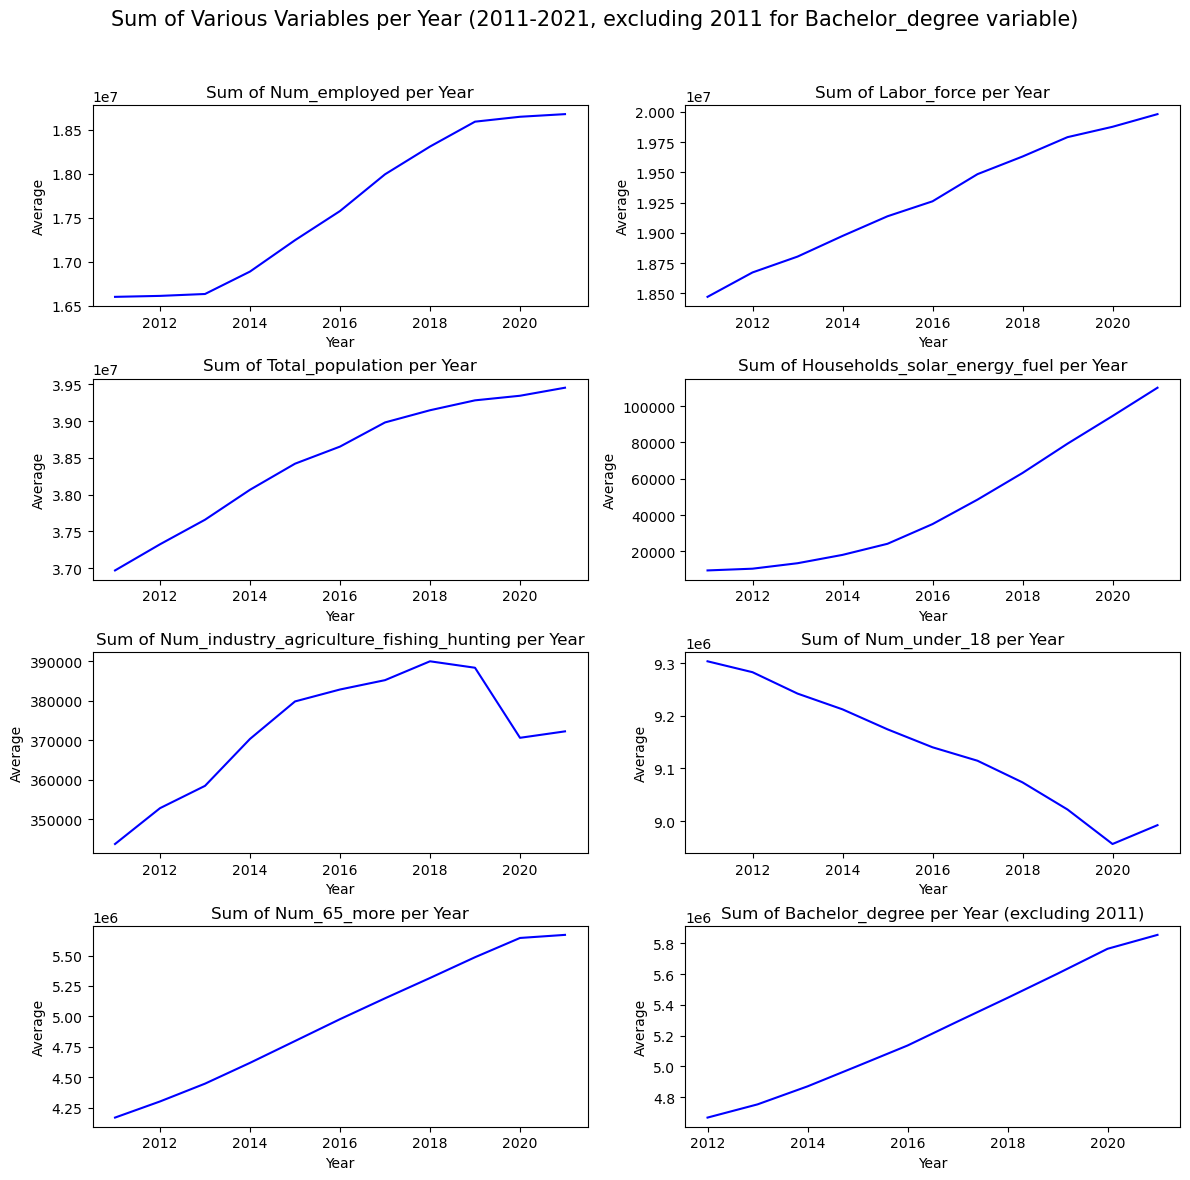

In [15]:
variables_to_explore = ['Num_employed', 'Labor_force', 'Total_population',
                        'Households_solar_energy_fuel', 'Num_industry_agriculture_fishing_hunting',
                        'Num_under_18', 'Num_65_more','Bachelor_degree'
                        ]
for_loop = ['Num_employed', 'Labor_force', 'Total_population',
                        'Households_solar_energy_fuel', 'Num_industry_agriculture_fishing_hunting',
                        'Num_under_18', 'Num_65_more'
                        ]
# Bachelor_degree must be taken a bit independendly because data for 2011 is missing

# Calculate sum of the variables (excluding 'Bachelor_degree') for each year
df_sum = df_census.groupby('Year')[variables_to_explore].sum().reset_index()

# Calculate number of rows and columns needed for subplots
num_plots = len(variables_to_explore) 
num_cols = 2
num_rows = (num_plots + 1) // (num_cols)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
axes = axes.flatten()

line_color = 'b'

# Iterate over the selected variables (excluding 'Bachelor_degree')
for i, variable in enumerate(for_loop):
    x = df_sum['Year']
    y = df_sum[variable]

    ax = axes[i]
    ax.plot(x, y, color=line_color)
    ax.set_xlabel('Year')
    ax.set_ylabel('Average')
    ax.set_title(f'Sum of {variable} per Year')

# Separate subplot for 'Bachelor_degree' (excluding 2011)
ax_bachelor = axes[-1]
x_bachelor = df_sum.loc[df_sum['Year'] != 2011, 'Year']
y_bachelor = df_sum.loc[df_sum['Year'] != 2011, 'Bachelor_degree']
ax_bachelor.plot(x_bachelor, y_bachelor, color=line_color)
ax_bachelor.set_xlabel('Year')
ax_bachelor.set_ylabel('Average')
ax_bachelor.set_title('Sum of Bachelor_degree per Year (excluding 2011)')

# Adjust the spacing
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Plot
fig.suptitle('Sum of Various Variables per Year (2011-2021, excluding 2011 for Bachelor_degree variable)', fontsize=15)
plt.show();


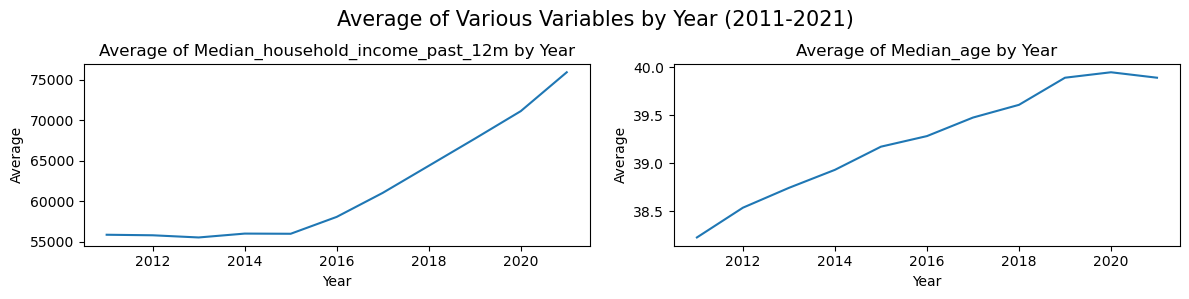

In [16]:
# There are the variables where we want to see the average of instead of sum 
variables_to_explore = ['Median_household_income_past_12m',
                        'Median_age',]

# Calculate average of the variables for each year
df_avg = df_census.groupby('Year')[variables_to_explore].mean().reset_index()

# Calculate number of rows and columns needed for subplots
num_plots = len(variables_to_explore)
num_cols = 2
num_rows = (num_plots + 1) // (num_cols)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12,3))

axes = axes.flatten()

# Iterate over the selected variables
for i, variable in enumerate(variables_to_explore):
    x = df_avg['Year']
    y = df_avg[variable]
    ax = axes[i]

    ax.plot(x, y)
    ax.set_xlabel('Year')
    ax.set_ylabel('Average')
    ax.set_title(f'Average of {variable} by Year')

# Adjust spacing
plt.tight_layout()
plt.subplots_adjust(top=0.8)

# Plot
fig.suptitle('Average of Various Variables by Year (2011-2021)', fontsize=15)
plt.show();

## Climate change opinions from americans <a class="anchor" id="OSF"></a>

### Cleaning <a class="anchor" id="OSF.1"></a>

In [17]:
df_opinions_cc = pd.read_spss('/project/CCAM SPSS Data 2008-2022.sav')
df_opinions_cc.head()

,case_ID,wave,year,weight_wave,weight_aggregate,happening,cause_original,cause_other_text,cause_recoded,sci_consensus,worry,harm_personally,harm_US,harm_dev_countries,harm_future_gen,harm_plants_animals,when_harm_US,reg_CO2_pollutant,reg_utilities,fund_research,reg_coal_emissions,discuss_GW,hear_GW_media,gender,age,age_category,generation,educ,educ_category,income,income_category,race,ideology,party,party_w_leaners,party_x_ideo,registered_voter,region9,region4,religion,religion_other_nonchristian,evangelical,service_attendance,marit_status,employment,house_head,house_size,house_ages0to1,house_ages2to5,house_ages6to12,house_ages13to17,house_ages18plus,house_type,house_own
0,2.0,Nov 2008,2008,0.54,0.269626,Yes,Caused mostly by human activities,,Caused mostly by human activities,Most scientists think global warming is happening,Somewhat worried,Only a little,A moderate amount,A great deal,A great deal,A great deal,In 10 years,Strongly support,Strongly support,Strongly support,NaN,Occasionally,NaN,Female,78.0,55+ years,Silent (1928 - 1945),High school graduate - high school diploma or ...,High school,"$50,000 to $59,999","$50,000 to $99,999","White, Non-Hispanic",Somewhat conservative,Republican,Republicans,Conservative Republican,Registered,South Atlantic,South,"Protestant (e.g., Methodist, Lutheran, Presbyt...",,No,Once a week,Widowed,Not working - retired,Not head of household,3.0,0.0,0.0,0.0,0.0,3.0,One-family house detached from any other house,Owned by you or someone in your household
1,3.0,Nov 2008,2008,0.85,0.424411,Don't know,Caused mostly by human activities,,Caused mostly by human activities,Don't know enough to say,Not very worried,Only a little,Refused,Only a little,A moderate amount,A moderate amount,In 50 years,Somewhat support,Somewhat support,Somewhat support,NaN,Rarely,NaN,Male,45.0,35-54 years,Baby Boomers (1946 - 1964),10th grade,Less than high school,"$30,000 to $34,999","Less than $50,000","White, Non-Hispanic","Moderate, middle of the road",No party/not interested in politics,No party/Not interested in politics,No Party/Not Interested in politics,Not registered,East-North Central,Midwest,"Protestant (e.g., Methodist, Lutheran, Presbyt...",,Don't Know,Once a year or less,Never married,Not working - disabled,Head of household,2.0,0.0,0.0,0.0,0.0,2.0,Mobile home,Rented
2,5.0,Nov 2008,2008,0.49,0.244660,Don't know,Caused mostly by natural changes in the enviro...,,Caused mostly by natural changes in the enviro...,There is a lot of disagreement among scientist...,Not at all worried,Not at all,Not at all,Not at all,Not at all,Not at all,Never,Somewhat oppose,Strongly oppose,Strongly oppose,NaN,Never,NaN,Female,54.0,35-54 years,Baby Boomers (1946 - 1964),Professional or Doctorate degree,Bachelor's degree or higher,"$30,000 to $34,999","Less than $50,000",Hispanic,Somewhat conservative,Republican,Republicans,Conservative Republican,Registered,Mountain,West,Mormon,,No,Once a week,Married,Not working - looking for work,Head of household,2.0,0.0,0.0,0.0,0.0,2.0,One-family house detached from any other house,Owned by you or someone in your household
3,6.0,Nov 2008,2008,0.29,0.144799,Yes,Caused mostly by natural changes in the enviro...,,Caused mostly by natural changes in the enviro...,Most scientists think global warming is happening,Somewhat worried,Only a little,Only a little,A moderate amount,A moderate amount,A moderate amount,In 25 years,Somewhat support,Strongly support,Strongly support,NaN,Rarely,NaN,Male,71.0,55+ years,Silent (1928 - 1945),Master's degree,Bachelor's degree or higher,"$100,000 to $124,999","$100,000 or more","White, Non-Hispanic",Somewhat conservative,Independent,Republicans,Conservative Republican,Registered,South Atlantic,South,"Protestant (e.g., Methodist, Lutheran, Presbyt...",,No,Once a year or less,Married,Not working - retired,Head of household,2.0,0.0,0.0,0.0,0.0,2.0,One-family house detached from any other house,Owned by you or someone in your household
4,7.0,Nov 2008,2008,1.29,0.644106

In [18]:
df_opinions_cc.columns

Index(['case_ID', 'wave', 'year', 'weight_wave', 'weight_aggregate',
       'happening', 'cause_original', 'cause_other_text', 'cause_recoded',
       'sci_consensus', 'worry', 'harm_personally', 'harm_US',
       'harm_dev_countries', 'harm_future_gen', 'harm_plants_animals',
       'when_harm_US', 'reg_CO2_pollutant', 'reg_utilities', 'fund_research',
       'reg_coal_emissions', 'discuss_GW', 'hear_GW_media', 'gender', 'age',
       'age_category', 'generation', 'educ', 'educ_category', 'income',
       'income_category', 'race', 'ideology', 'party', 'party_w_leaners',
       'party_x_ideo', 'registered_voter', 'region9', 'region4', 'religion',
       'religion_other_nonchristian', 'evangelical', 'service_attendance',
       'marit_status', 'employment', 'house_head', 'house_size',
       'house_ages0to1', 'house_ages2to5', 'house_ages6to12',
       'house_ages13to17', 'house_ages18plus', 'house_type', 'house_own'],
      dtype='object')

In [19]:
df_opinions_cc.year.unique()

['2008', '2010', '2011', '2012', '2013', ..., '2018', '2019', '2020', '2021', '2022']
Length: 14
Categories (14, object): ['2008', '2010', '2011', '2012', ..., '2019', '2020', '2021', '2022']

In [20]:
df_opinions_cc.region9.unique()

['South Atlantic', 'East-North Central', 'Mountain', 'East-South Central', 'Pacific', 'Mid-Atlantic', 'West-South Central', 'West-North Central', 'New England']
Categories (9, object): ['East-North Central', 'East-South Central', 'Mid-Atlantic', 'Mountain', ..., 'Pacific', 'South Atlantic', 'West-North Central', 'West-South Central']

Pacific = AK,CA,HI,OR,WA where CA represent California, 
so we're keeping that only

In [21]:
df_opinions_cc = df_opinions_cc[df_opinions_cc['region9']=='Pacific']

dropping the year 2008 because 2009 is missing

In [22]:
df_opinions_cc = df_opinions_cc[df_opinions_cc['year'] != '2008']

In [23]:
df_opinions_cc.year.unique()

['2010', '2011', '2012', '2013', '2014', ..., '2018', '2019', '2020', '2021', '2022']
Length: 13
Categories (14, object): ['2008', '2010', '2011', '2012', ..., '2019', '2020', '2021', '2022']

In [24]:
df_opinions_cc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4334 entries, 2164 to 30126
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   case_ID                      4334 non-null   float64 
 1   wave                         4334 non-null   category
 2   year                         4334 non-null   category
 3   weight_wave                  4334 non-null   float64 
 4   weight_aggregate             4334 non-null   float64 
 5   happening                    4334 non-null   category
 6   cause_original               4334 non-null   category
 7   cause_other_text             4334 non-null   object  
 8   cause_recoded                4334 non-null   category
 9   sci_consensus                4121 non-null   category
 10  worry                        4334 non-null   category
 11  harm_personally              4334 non-null   category
 12  harm_US                      4334 non-null   category
 13 

In [25]:
null_counts = df_opinions_cc.isnull().sum().reset_index().rename(columns={"index": "Column", 0: "Null Count"}).sort_values(by="Null Count", ascending=False)
null_counts["Null Percentage"] = (null_counts["Null Count"] / len(df_opinions_cc)) * 100

In [26]:
null_counts.head(15)

,Column,Null Count,Null Percentage
20,reg_coal_emissions,1894,43.700969
22,hear_GW_media,1747,40.309183
18,reg_utilities,1434,33.087217
47,house_ages0to1,471,10.867559
43,marit_status,471,10.867559
44,employment,471,10.867559
45,house_head,471,10.867559
48,house_ages2to5,471,10.867559
49,house_ages6to12,471,10.867559
50,house_ages13to17,471,10.867559


we will drop the top 3 missing variables. They were not asked every year and don't seem to be the most important variables. Additionally, there are too many missing values to impute them. Plus the houses and house type will not add anything to our analysis and are not variables we need for our future model, same with house_head or marit_status.

In [27]:
df_opinions_cc.drop(columns = ['reg_coal_emissions','hear_GW_media','reg_utilities','house_ages0to1','marit_status','house_head'
                               ,'house_ages2to5','house_ages6to12','house_ages13to17','house_type'], inplace=True)

In [28]:
null_rows = df_opinions_cc[df_opinions_cc['harm_plants_animals'].isnull()]

null_rows.head()

,case_ID,wave,year,weight_wave,weight_aggregate,happening,cause_original,cause_other_text,cause_recoded,sci_consensus,worry,harm_personally,harm_US,harm_dev_countries,harm_future_gen,harm_plants_animals,when_harm_US,reg_CO2_pollutant,fund_research,discuss_GW,gender,age,age_category,generation,educ,educ_category,income,income_category,race,ideology,party,party_w_leaners,party_x_ideo,registered_voter,region9,region4,religion,religion_other_nonchristian,evangelical,service_attendance,employment,house_size,house_ages18plus,house_own
13697,26006.0,Oct 2015,2015,0.5506,0.447311,Yes,Caused mostly by natural changes in the enviro...,,Caused mostly by natural changes in the enviro...,NaN,Somewhat worried,A moderate amount,A moderate amount,A great deal,A great deal,NaN,They are being harmed now,Somewhat support,Somewhat support,Occasionally,Male,67.0,55+ years,Baby Boomers (1946 - 1964),"Some college, no degree",Some college,"Less than $5,000","Less than $50,000","White, Non-Hispanic","Moderate, middle of the road",Independent,Republicans,Liberal/Moderate Republican,Not registered,Pacific,West,"Protestant (e.g., Methodist, Lutheran, Presbyt...",,No,Once or twice a month,Not working - looking for work,2.0,2.0,Owned by you or someone in your household
13699,26008.0,Oct 2015,2015,0.6041,0.490774,Yes,Caused mostly by human activities,,Caused mostly by human activities,NaN,Somewhat worried,Only a little,A great deal,A great deal,A great deal,NaN,In 25 years,Strongly support,Somewhat support,Occasionally,Male,72.0,55+ years,Silent (1928 - 1945),"Some college, no degree",Some college,"$40,000 to $49,999","Less than $50,000","White, Non-Hispanic",Somewhat liberal,Democrat,Democrats,Liberal Democrat,Registered,Pacific,West,"Protestant (e.g., Methodist, Lutheran, Presbyt...",,No,Once a year or less,Not working - retired,1.0,1.0,Owned by you or someone in your household
13704,26014.0,Oct 2015,2015,1.2972,1.053853,Yes,Caused mostly by human activities,,Caused mostly by human activities,NaN,Very worried,A great deal,A great deal,A great deal,A great deal,NaN,In 25 years,Strongly support,Strongly support,Occasionally,Male,72.0,55+ years,Silent (1928 - 1945),Master's degree,Bachelor's degree or higher,"$125,000 to $149,999","$100,000 or more","Other, Non-Hispanic",Very liberal,Independent,Democrats,Liberal Democrat,Registered,Pacific,West,"Protestant (e.g., Methodist, Lutheran, Presbyt...",,No,Never,Working - self-employed,2.0,2.0,Owned by you or someone in your household
13718,26028.0,Oct 2015,2015,1.1495,0.933861,Yes,Caused mostly by natural changes in the enviro...,,Caused mostly by natural changes in the enviro...,NaN,Somewhat worried,Only a little,A moderate amount,A great deal,A great deal,NaN,They are being harmed now,Somewhat support,Strongly support,Occasionally,Male,71.0,55+ years,Silent (1928 - 1945),Associate's degree,Some college,"$100,000 to $124,999","$100,000 or more","White, Non-Hispanic","Moderate, middle of the road",Independent,Democrats,Moderate/Conservative Democrat,Registered,Pacific,West,"Protestant (e.g., Methodist, Lutheran, Presbyt...",,No,Never,Not working - retired,1.0,1.0,Owned by you or someone in your household
13721,26031.0,Oct 2015,2015,1.6015,1.301068,Yes,Caused mostly by human activities,,Caused mostly by human activities,NaN,Very worried,A great deal,A great deal,A great deal,A great deal,NaN,They are being harmed now,Somewhat support,Somewhat support,Often,Female,34.0,18-34 years,Millennials (1981 - 1996),Master's degree,Bachelor's degree or higher,"$175,000 to $199,999 (Nov 2016 on); $175,000 o...","$100,000 or more","Other, Non-Hispanic",Somewhat conservative,Independent,Independent/Other,Independent (Non-Leaning),Registered,Pacific,West,None of the Above (Apr 2014 on); None (Nov 200...,,Yes,Once a year or less,Working - as a paid employee,4.0,2.0,Owned by you or someone in your household


In [29]:
null_rows.year.unique()

['2015']
Categories (14, object): ['2008', '2010', '2011', '2012', ..., '2019', '2020', '2021', '2022']

Using KNN imputer to impute the missing values of these 2 columns which are each missing values for one year each

In [30]:
df_opinions_osf = df_opinions_cc.copy()

# Columns that need imputation
cols_to_impute = ['sci_consensus', 'harm_plants_animals']

# Create a mapping from numerical values to original categories for each column
mappings = {}
for col in cols_to_impute:
    df_opinions_osf[col] = df_opinions_osf[col].astype('category')
    mappings[col] = dict(enumerate(df_opinions_osf[col].cat.categories))

# Convert categorical variables to numerical values
for col in cols_to_impute:
    df_opinions_osf[col] = df_opinions_osf[col].cat.codes

# Replace -1 with np.nan (because the numerical value -1 represents missing values)
df_opinions_osf[cols_to_impute] = df_opinions_osf[cols_to_impute].replace(-1, np.nan)

# Initialize the KNN imputer & perform imputation
imputer = KNNImputer(n_neighbors=5)
df_opinions_osf[cols_to_impute] = imputer.fit_transform(df_opinions_osf[cols_to_impute])

# Since the imputation might result in non-integer values, we might want to round them off or convert to appropriate types
for col in cols_to_impute:
    df_opinions_osf[col] = df_opinions_osf[col].round().astype(int)

# Convert the numerical values back to their original categories
for col in cols_to_impute:
    df_opinions_osf[col] = df_opinions_osf[col].apply(lambda x: mappings[col].get(x, np.nan))


Checking the null values left after the steps previously taken.

In [31]:
null_counts = df_opinions_osf.isnull().sum().reset_index().rename(columns={"index": "Column", 0: "Null Count"}).sort_values(by="Null Count", ascending=False)
null_counts["Null Percentage"] = (null_counts["Null Count"] / len(df_opinions_osf)) * 100

In [32]:
null_counts.head()

,Column,Null Count,Null Percentage
40,employment,471,10.867559
17,reg_CO2_pollutant,161,3.714813
0,case_ID,0,0.000000
32,party_x_ideo,0,0.000000
25,educ_category,0,0.000000


In [33]:
df_opinions_osf.employment.unique()

['Not working - disabled', 'Working - as a paid employee', 'Not working - retired', 'Not working - looking for work', 'Not working - other', 'Working - self-employed', 'Not working - on temporary layoff from a job', NaN]
Categories (7, object): ['Not working - disabled', 'Not working - looking for work', 'Not working - on temporary layoff from a job', 'Not working - other', 'Not working - retired', 'Working - as a paid employee', 'Working - self-employed']

In [34]:
null_rows = df_opinions_osf[df_opinions_osf['employment'].isnull()]

null_rows.head()

,case_ID,wave,year,weight_wave,weight_aggregate,happening,cause_original,cause_other_text,cause_recoded,sci_consensus,worry,harm_personally,harm_US,harm_dev_countries,harm_future_gen,harm_plants_animals,when_harm_US,reg_CO2_pollutant,fund_research,discuss_GW,gender,age,age_category,generation,educ,educ_category,income,income_category,race,ideology,party,party_w_leaners,party_x_ideo,registered_voter,region9,region4,religion,religion_other_nonchristian,evangelical,service_attendance,employment,house_size,house_ages18plus,house_own
27101,48028.0,Mar 2021,2021,1.2213,1.272531,Yes,Caused mostly by human activities,,Caused mostly by human activities,Most scientists think global warming is happening,Very worried,A moderate amount,A moderate amount,A great deal,A great deal,A great deal,In 10 years,Somewhat support,Somewhat support,Occasionally,Male,58.0,55+ years,Baby Boomers (1946 - 1964),Associate's degree,Some college,"$85,000 to $99,999","$50,000 to $99,999","Other, Non-Hispanic","Moderate, middle of the road",Republican,Republicans,Liberal/Moderate Republican,Registered,Pacific,West,Hindu,-1,No,A few times a year,NaN,4.0,4.0,Owned by you or someone in your household
27102,48029.0,Mar 2021,2021,1.2836,1.337444,Yes,Caused mostly by human activities,,Caused mostly by human activities,Most scientists think global warming is happening,Very worried,A great deal,A great deal,A great deal,A great deal,A great deal,They are being harmed now,Strongly support,Strongly support,Occasionally,Female,28.0,18-34 years,Millennials (1981 - 1996),Master's degree,Bachelor's degree or higher,"$250,000 or more (Nov 2016 on)","$100,000 or more","White, Non-Hispanic",Somewhat liberal,Democrat,Democrats,Liberal Democrat,Registered,Pacific,West,Mormon,-1,No,Once a week,NaN,2.0,2.0,Owned by you or someone in your household
27105,48032.0,Mar 2021,2021,0.5622,0.585783,Yes,Other (Please specify),A combination of things,Caused by human activities and natural changes,Most scientists think global warming is happening,Somewhat worried,Only a little,A moderate amount,A great deal,A great deal,A great deal,In 50 years,Somewhat support,Somewhat support,Rarely,Male,65.0,55+ years,Baby Boomers (1946 - 1964),Master's degree,Bachelor's degree or higher,"$40,000 to $49,999","Less than $50,000","White, Non-Hispanic",Somewhat conservative,Republican,Republicans,Conservative Republican,Registered,Pacific,West,Baptist - any denomination,-1,Yes,More than once a week,NaN,3.0,3.0,Owned by you or someone in your household
27107,48034.0,Mar 2021,2021,1.6537,1.723069,Yes,Caused mostly by human activities,,Caused mostly by human activities,Most scientists think global warming is happening,Very worried,A moderate amount,A moderate amount,A great deal,A great deal,A great deal,In 10 years,Strongly support,Strongly support,Occasionally,Male,50.0,35-54 years,Generation X (1965 - 1980),7th or 8th grade,Less than high school,"$175,000 to $199,999 (Nov 2016 on); $175,000 o...","$100,000 or more",Hispanic,"Moderate, middle of the road",Democrat,Democrats,Moderate/Conservative Democrat,Not registered,Pacific,West,Catholic,-1,No,Once a year or less,NaN,4.0,4.0,Owned by you or someone in your household
27109,48036.0,Mar 2021,2021,0.6845,0.713213,Yes,Caused mostly by human activities,,Caused mostly by human activities,There is a lot of disagreement among scientist...,Somewhat worried,A moderate amount,A moderate amount,A moderate amount,A great deal,A moderate amount,In 50 years,Somewhat oppose,Somewhat support,Rarely,Male,47.0,35-54 years,Generation X (1965 - 1980),Bachelor's degree,Bachelor's degree or higher,"$150,000 to $174,999","$100,000 or more","White, Non-Hispanic","Moderate, middle of the road",Republican,Republicans,Liberal/Moderate Republican,Not registered,Pacific,West,None of the Above (Apr 2014 on); None (Nov 200...,-1,No,Never,NaN,4.0,3.0,Rented


In [35]:
null_rows.year.unique()

['2021', '2022']
Categories (14, object): ['2008', '2010', '2011', '2012', ..., '2019', '2020', '2021', '2022']

employment is missing for 2021 and 2022, no accurate way of imputing it because covid fundamentally changed the employment status of many, thus we drop the column. We will have this data on another dataset so we are not missing out on information.

In [36]:
df_opinions_osf.drop(columns=['employment'], inplace=True)

In [37]:
df_opinions_osf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4334 entries, 2164 to 30126
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   case_ID                      4334 non-null   float64 
 1   wave                         4334 non-null   category
 2   year                         4334 non-null   category
 3   weight_wave                  4334 non-null   float64 
 4   weight_aggregate             4334 non-null   float64 
 5   happening                    4334 non-null   category
 6   cause_original               4334 non-null   category
 7   cause_other_text             4334 non-null   object  
 8   cause_recoded                4334 non-null   category
 9   sci_consensus                4334 non-null   object  
 10  worry                        4334 non-null   category
 11  harm_personally              4334 non-null   category
 12  harm_US                      4334 non-null   category
 13 

Will drop the other text values to keep the categorical columns only, plus only keeping age_category, educ_category and income_category which are based on the previous open ended questions or questions with many categories.

We also don't need the case identifier or the weight of each wave since we're looking at the evolution of these variables and the corresponding answers.

Plus, there are 3 questions around the cause of global warming, but only keeping cause_recorded as this was categorical only and the last one. 

While could be interesting to keep religion, no need for the open-ended religion question, evangelical or service_attendance.

In [38]:
df_opinions_osf.drop(columns=['case_ID','weight_wave','weight_aggregate','wave','cause_original','cause_other_text','reg_CO2_pollutant','fund_research',
                              'age','generation','educ','income','race','ideology','party','party_w_leaners','party_x_ideo','registered_voter',
                             'region9','region4','religion','religion_other_nonchristian','evangelical','service_attendance','house_ages18plus'
                            ],inplace=True)

In [39]:
df_opinions_osf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4334 entries, 2164 to 30126
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   year                 4334 non-null   category
 1   happening            4334 non-null   category
 2   cause_recoded        4334 non-null   category
 3   sci_consensus        4334 non-null   object  
 4   worry                4334 non-null   category
 5   harm_personally      4334 non-null   category
 6   harm_US              4334 non-null   category
 7   harm_dev_countries   4334 non-null   category
 8   harm_future_gen      4334 non-null   category
 9   harm_plants_animals  4334 non-null   object  
 10  when_harm_US         4334 non-null   category
 11  discuss_GW           4334 non-null   category
 12  gender               4334 non-null   category
 13  age_category         4334 non-null   category
 14  educ_category        4334 non-null   category
 15  income_category  

In [40]:
df_opinions_osf.head()

,year,happening,cause_recoded,sci_consensus,worry,harm_personally,harm_US,harm_dev_countries,harm_future_gen,harm_plants_animals,when_harm_US,discuss_GW,gender,age_category,educ_category,income_category,house_size,house_own
2164,2010,Don't know,Caused mostly by human activities,Most scientists think global warming is happening,Somewhat worried,A moderate amount,A moderate amount,A moderate amount,Only a little,Only a little,In 100 years,Never,Male,18-34 years,Less than high school,"Less than $50,000",1.0,Rented
2165,2010,Yes,Caused mostly by human activities,There is a lot of disagreement among scientist...,Somewhat worried,A moderate amount,A moderate amount,A moderate amount,A great deal,A great deal,In 100 years,Rarely,Male,18-34 years,Some college,"Less than $50,000",4.0,Rented
2166,2010,Yes,Caused mostly by human activities,Don't know enough to say,Not very worried,Not at all,Only a little,Only a little,Only a little,Only a little,In 10 years,Rarely,Male,55+ years,Bachelor's degree or higher,"$50,000 to $99,999",1.0,Owned by you or someone in your household
2199,2010,Yes,Caused mostly by human activities,Most scientists think global warming is happening,Very worried,A great deal,A great deal,A great deal,A great deal,A great deal,In 10 years,Occasionally,Female,55+ years,High school,"Less than $50,000",2.0,Rented
2222,2010,Don't know,Caused mostly by natural changes in the enviro...,There is a lot of disagreement among scientist...,Not very worried,Only a little,Only a little,Only a little,Only a little,Only a little,In 50 years,Never,Male,55+ years,Bachelor's degree or higher,"$50,000 to $99,999",4.0,Owned by you or someone in your household


In [41]:
# Convert 'year' column to integer
df_opinions_osf['year'] = df_opinions_osf['year'].astype(int)

# Convert 'sci_consensus' and 'harm_plants_animals' columns to categorical
df_opinions_osf['sci_consensus'] = df_opinions_osf['sci_consensus'].astype('category')
df_opinions_osf['harm_plants_animals'] = df_opinions_osf['harm_plants_animals'].astype('category')

# Print the updated DataFrame
print(df_opinions_osf.dtypes)

year                      int64
happening              category
cause_recoded          category
sci_consensus          category
worry                  category
harm_personally        category
harm_US                category
harm_dev_countries     category
harm_future_gen        category
harm_plants_animals    category
when_harm_US           category
discuss_GW             category
gender                 category
age_category           category
educ_category          category
income_category        category
house_size              float64
house_own              category
dtype: object


In [42]:
df_opinions_osf

,year,happening,cause_recoded,sci_consensus,worry,harm_personally,harm_US,harm_dev_countries,harm_future_gen,harm_plants_animals,when_harm_US,discuss_GW,gender,age_category,educ_category,income_category,house_size,house_own
2164,2010,Don't know,Caused mostly by human activities,Most scientists think global warming is happening,Somewhat worried,A moderate amount,A moderate amount,A moderate amount,Only a little,Only a little,In 100 years,Never,Male,18-34 years,Less than high school,"Less than $50,000",1.0,Rented
2165,2010,Yes,Caused mostly by human activities,There is a lot of disagreement among scientist...,Somewhat worried,A moderate amount,A moderate amount,A moderate amount,A great deal,A great deal,In 100 years,Rarely,Male,18-34 years,Some college,"Less than $50,000",4.0,Rented
2166,2010,Yes,Caused mostly by human activities,Don't know enough to say,Not very worried,Not at all,Only a little,Only a little,Only a little,Only a little,In 10 years,Rarely,Male,55+ years,Bachelor's degree or higher,"$50,000 to $99,999",1.0,Owned by you or someone in your household
2199,2010,Yes,Caused mostly by human activities,Most scientists think global warming is happening,Very worried,A great deal,A great deal,A great deal,A great deal,A great deal,In 10 years,Occasionally,Female,55+ years,High school,"Less than $50,000",2.0,Rented
2222,2010,Don't know,Caused mostly by natural changes in the enviro...,There is a lot of disagreement among scientist...,Not very worried,Only a little,Only a little,Only a little,Only a little,Only a little,In 50 years,Never,Male,55+ years,Bachelor's degree or higher,"$50,000 to $99,999",4.0,Owned by you or someone in your household
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30085,2022,Don't know,Caused mostly by natural changes in the enviro...,There is a lot of disagreement among scientist...,Not very worried,Only a little,Only a little,Only a little,Only a little,Only a little,In 25 years,Never,Female,35-54 years,Some college,"$100,000 or more",3.0,Owned by you or someone in your household
30097,2022,Yes,Caused mostly by human activities,Most scientists think global warming is happening,Very worried,Only a little,A moderate amount,A great deal,A great deal,A great deal,They are being harmed now,Occasionally,Female,55+ years,High school,"$100,000 or more",7.0,Owned by you or someone in your household
30112,2022,No,Caused mostly by natural changes in the enviro...,There is a lot of disagreement among scientist...,Not at all worried,Not at all,Not at all,Not at all,Not at all,Not at all,Never,Never,Male,55+ years,High school,"$50,000 to $99,999",2.0,Owned by you or someone in your household
30121,2022,Yes,Caused mostly by human activities,Most scientists think global warming is happening,Very worried,A great deal,A great deal,Don't know,A great deal,A great deal,In 10 years,Rarely,Male,55+ years,Bachelor's degree or higher,"$100,000 or more",2.0,Owned by you or someone in your household


### EDA <a class="anchor" id="YCCOM.2"></a>

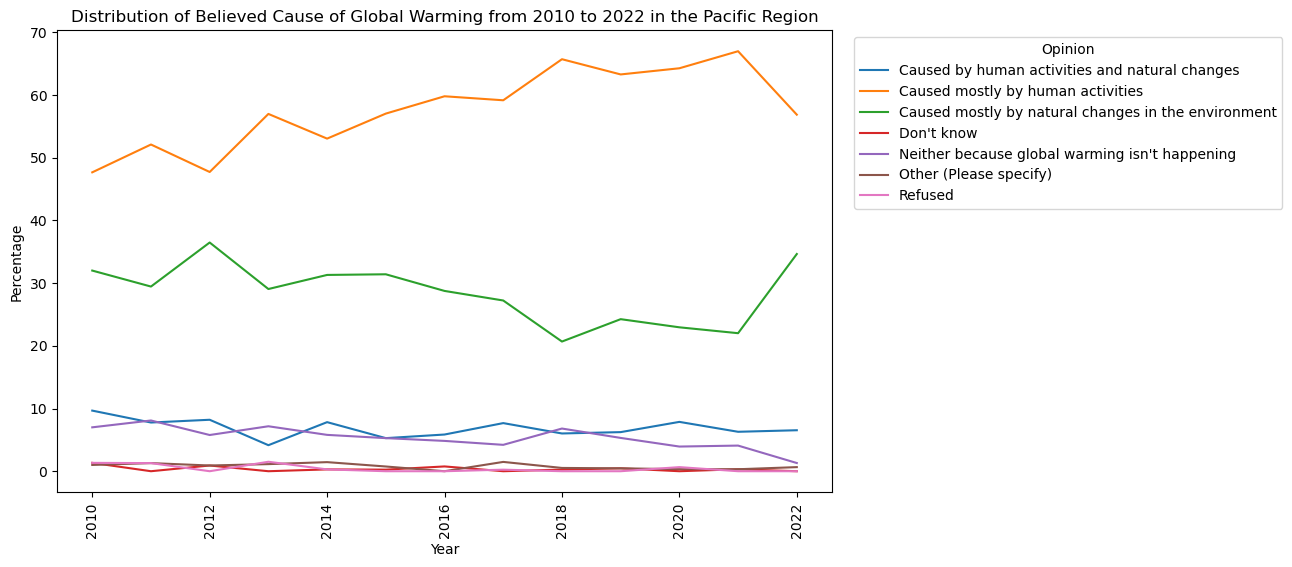

In [43]:
# Filter out the data for all years except 2008 - while 2008 is not in this dataframe anymore, it is shown as a category for the variable year, showing 2008 on the plot. This solves this problem.
df_filtered = df_opinions_osf[df_opinions_osf['year'] != '2008']

# Convert 'year' column to numeric type
df_filtered['year'] = pd.to_numeric(df_filtered['year'])

# Calculate the percentage for each category
total_counts = df_filtered.groupby('year')['cause_recoded'].count()
percentage = df_filtered.groupby(['year', 'cause_recoded']).size() / total_counts * 100

# Reset index to ensure proper plotting
percentage = percentage.reset_index()

# Create a line plot for the 'cause_recoded' column over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y=0, hue='cause_recoded', data=percentage)
plt.title('Distribution of Believed Cause of Global Warming from 2010 to 2022 in the Pacific Region')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend(title='Opinion', bbox_to_anchor=(1.02, 1), loc='upper left') 
plt.xticks(rotation=90)
plt.show();

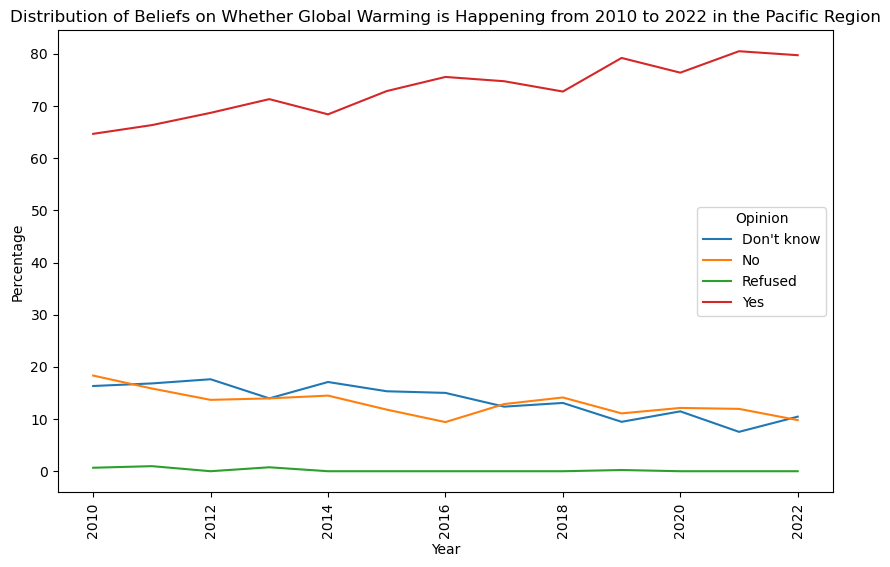

In [44]:
# Calculate the percentage for each category
total_counts = df_filtered.groupby('year')['happening'].count()
percentage = df_filtered.groupby(['year', 'happening']).size() / total_counts * 100

# Reset index to ensure proper plotting
percentage = percentage.reset_index()

# Create a line plot for the 'happening' column over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y=0, hue='happening', data=percentage)
plt.title('Distribution of Beliefs on Whether Global Warming is Happening from 2010 to 2022 in the Pacific Region')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend(title='Opinion')
plt.xticks(rotation=90)
plt.show();

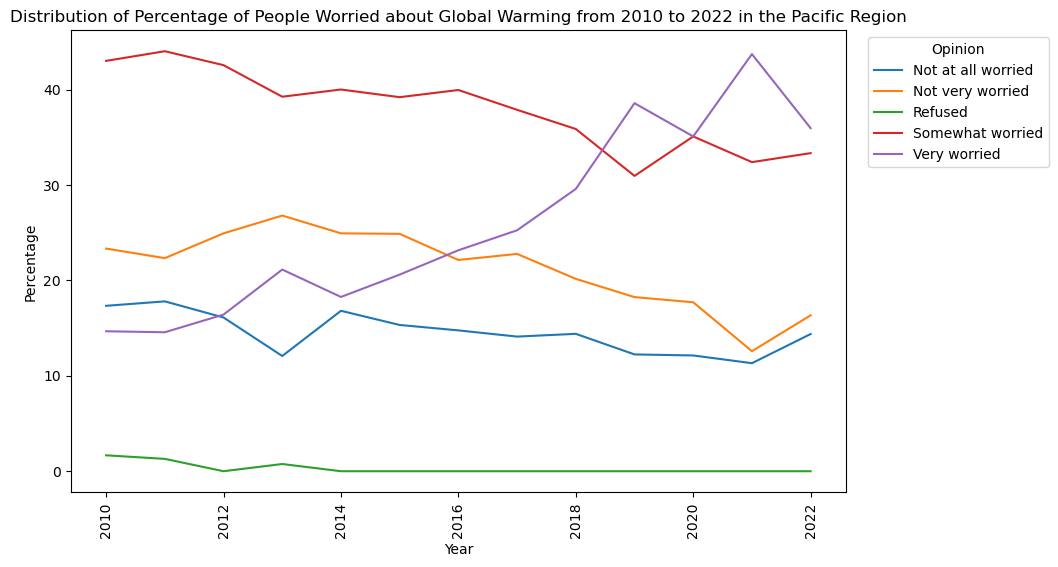

In [45]:
# Calculate the percentage for each category
total_counts = df_filtered.groupby('year')['worry'].count()
percentage = df_filtered.groupby(['year', 'worry']).size() / total_counts * 100

# Reset index to ensure proper plotting
percentage = percentage.reset_index()

# Create plot for the 'cause_recoded' column over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y=0, hue='worry', data=percentage)
plt.title('Distribution of Percentage of People Worried about Global Warming from 2010 to 2022 in the Pacific Region')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend(title='Opinion', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=90)
plt.show();

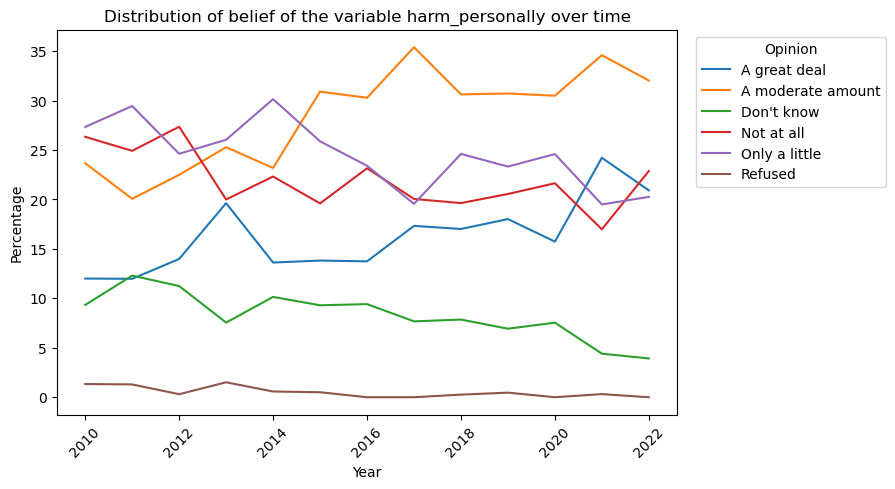

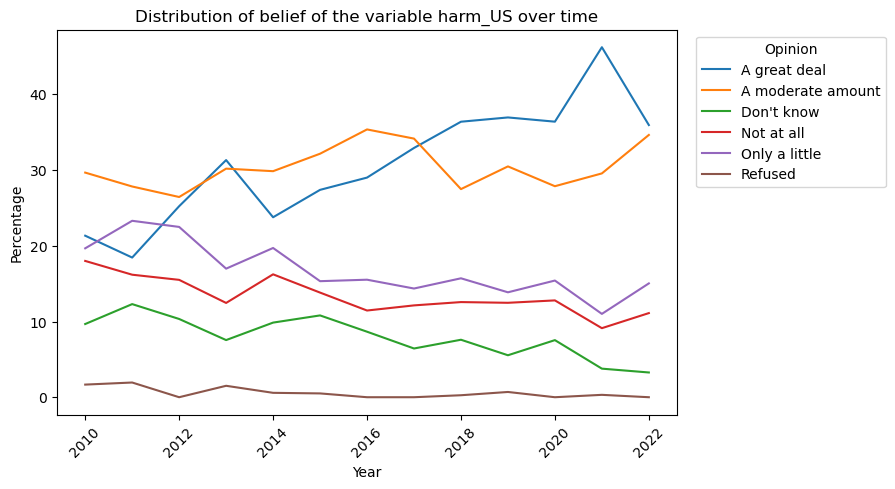

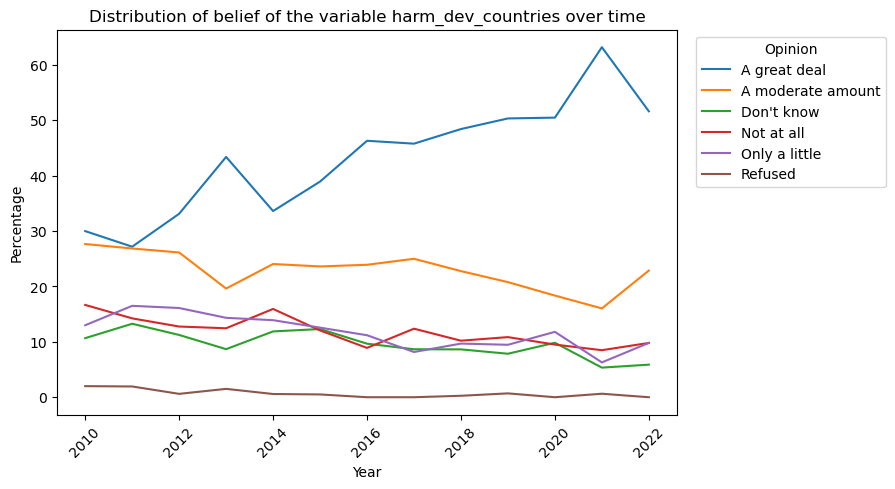

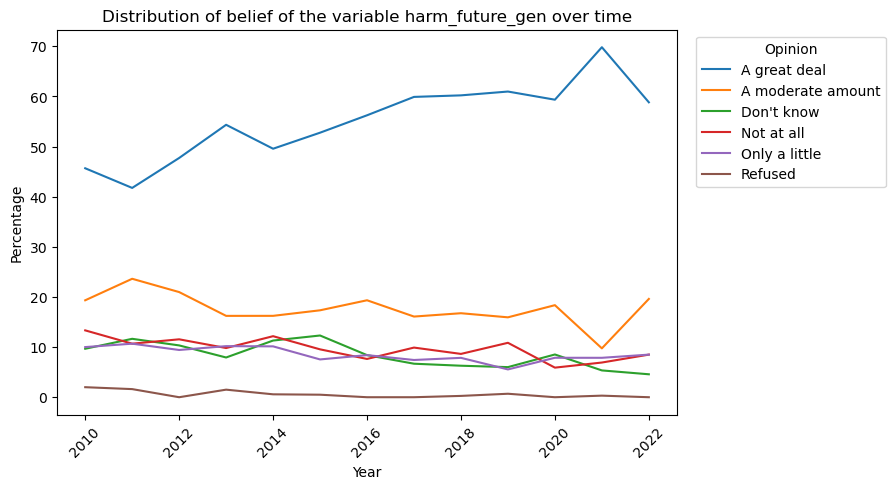

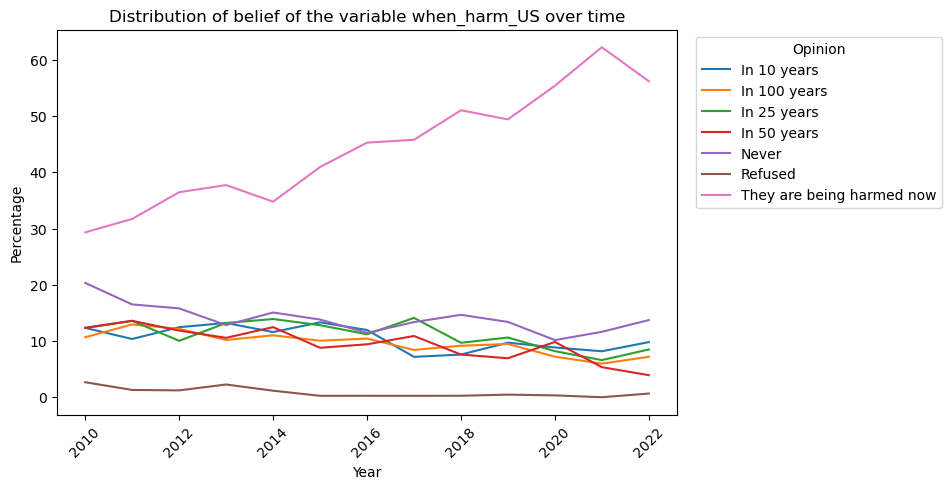

In [46]:
columns_exploring = ['harm_personally','harm_US','harm_dev_countries','harm_future_gen','when_harm_US']

for col in columns_exploring:
    # Calculate the percentage for each category
    total_counts = df_filtered.groupby('year')[col].count()
    percentage = df_filtered.groupby(['year', col]).size() / total_counts * 100

    # Reset index to ensure proper plotting
    percentage = percentage.reset_index()

    # Create plot for the each column over time
    plt.figure(figsize=(8,5))
    sns.lineplot(x='year', y=0, hue=col, data=percentage)
    plt.title(f'Distribution of belief of the variable {col} over time')
    plt.xlabel('Year')
    plt.ylabel('Percentage')
    plt.legend(title='Opinion', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.show();
    
plt.show();

## Yale climate change opinions Maps (YCCOM) <a class="anchor" id="YCCOM"></a>

In [47]:
df_yale_cc = pd.read_excel("/project/ycom.coot.2008-2021.xlsx", sheet_name="ycom2014-2021.coot2008-2020")

In [48]:
df_yale_cc.head()

,varname,GEOID,GeoName,GeoType,2008,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,congress,1.0,Alabama,State,58.981908,49.802614,49.765859,53.228234,51.458185,47.786980,53.212674,52.105523,54.264808,57.941226,54.301949,54.258945,54.046
1,congress,2.0,Alaska,State,60.132746,46.002393,49.131080,51.257517,50.987592,49.746340,54.457395,55.638666,58.447552,59.277305,57.337735,55.995996,57.283
2,congress,4.0,Arizona,State,61.998327,50.883474,52.868549,55.486015,52.692013,52.763085,56.921733,58.611543,60.467437,61.793629,59.464964,58.594975,60.166
3,congress,5.0,Arkansas,State,59.723048,48.937187,48.386756,52.154763,50.748722,48.179800,53.114320,52.970622,55.432803,57.857793,55.320774,54.950286,56.360
4,congress,6.0,California,State,65.641937,55.107412,57.686804,62.078066,61.100128,59.067086,64.717127,68.530911,67.226963,68.363890,66.629989,62.498390,65.822


## Cleaning<a class="anchor" id="YCCOM.1"></a>

#### pivot the table

In [49]:
# Define the columns that will not be melted
id_vars = ['varname', 'GEOID', 'GeoName', 'GeoType']

# Melt the dataframe from wide to long format
df_melted = pd.melt(df_yale_cc, 
                    id_vars=id_vars, 
                    value_vars=[year for year in range(2008, 2022) if year != 2009],
                    var_name='Year', 
                    value_name='Value')

# Rename the columns
df_melted = df_melted.rename(columns={'varname': 'varname',
                                      'GEOID': 'GEOID',
                                      'GeoName': 'GeoName',
                                      'GeoType': 'GeoType',
                                      'Year': 'Year',
                                      'Value': 'VarValue'})

# Reorder columns if necessary
df_melted = df_melted[['GEOID', 'GeoName', 'GeoType', 'Year', 'varname', 'VarValue']]

In [50]:
# Pivot the table
df_pivot = df_melted.pivot_table(index=['GEOID', 'GeoName', 'GeoType', 'Year'], 
                                 columns='varname', 
                                 values='VarValue').reset_index()

# "Flatten" the DataFrame, converting the multi-index columns into a single level
df_pivot.columns = df_pivot.columns.get_level_values(0)

In [51]:
df_pivot

varname,GEOID,GeoName,GeoType,Year,CO2limits,CO2limitsOppose,affectweather,affectweatherOppose,citizens,citizensOppose,congress,congressOppose,consensus,consensusOppose,corporations,corporationsOppose,devharm,devharmOppose,discuss,discussOppose,drillANWR,drillANWROppose,drilloffshore,drilloffshoreOppose,exp,expOppose,fundrenewables,fundrenewablesOppose,futuregen,futuregenOppose,governor,governorOppose,gwvoteimp,gwvoteimpOppose,happening,happeningOppose,harmUS,harmUSOppose,harmplants,harmplantsOppose,human,humanOppose,important,localofficials,localofficialsOppose,mediaweekly,mediaweeklyOppose,personal,personalOppose,president,presidentOppose,prienv,prienvOppose,priority,priorityOppose,rebates,rebatesOppose,reducetax,reducetaxOppose,regulate,regulateOppose,supportRPS,supportRPSOppose,taxdividend,taxdividendOppose,teachGW,teachGWOppose,timing,timingOppose,trustclimsciSST,trustclimsciSSTOppose,worried,worriedOppose
0,1.0,Alabama,State,2008,NaN,NaN,NaN,NaN,NaN,NaN,58.981908,NaN,35.067285,NaN,NaN,NaN,NaN,NaN,32.728959,NaN,NaN,NaN,NaN,NaN,27.745265,NaN,85.074926,NaN,48.632861,NaN,56.034601,NaN,NaN,NaN,61.222443,NaN,42.085315,NaN,NaN,NaN,50.394398,NaN,24.013838,54.141219,NaN,NaN,NaN,27.255974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.474124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.823650,NaN,NaN,NaN,54.967371,NaN
1,1.0,Alabama,State,2010,NaN,NaN,NaN,NaN,NaN,NaN,49.802614,NaN,23.546497,NaN,NaN,NaN,NaN,NaN,32.248646,NaN,NaN,NaN,NaN,NaN,24.469200,NaN,83.442326,NaN,53.112479,NaN,47.663626,NaN,NaN,NaN,51.679738,NaN,42.754888,NaN,NaN,NaN,46.271865,NaN,17.416385,46.250336,NaN,NaN,NaN,33.178700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.931641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.286973,NaN,NaN,NaN,46.554934,NaN
2,1.0,Alabama,State,2011,NaN,NaN,NaN,NaN,NaN,NaN,49.765859,NaN,29.806465,NaN,NaN,NaN,NaN,NaN,23.650334,NaN,NaN,NaN,NaN,NaN,29.970210,NaN,71.764111,NaN,51.264964,NaN,49.844315,NaN,NaN,NaN,53.962728,NaN,37.408897,NaN,NaN,NaN,43.578538,NaN,17.012040,47.394859,NaN,NaN,NaN,26.797488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.628623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.688857,NaN,NaN,NaN,44.826468,NaN
3,1.0,Alabama,State,2012,NaN,NaN,NaN,NaN,NaN,NaN,53.228234,NaN,28.832258,NaN,NaN,NaN,NaN,NaN,24.522404,NaN,NaN,NaN,NaN,NaN,31.704022,NaN,71.579140,NaN,54.278025,NaN,49.374670,NaN,NaN,NaN,59.036682,NaN,48.032255,NaN,NaN,NaN,43.589111,NaN,19.107550,47.266973,NaN,NaN,NaN,33.794104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.950348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.832803,NaN,NaN,NaN,44.443922,NaN
4,1.0,Alabama,State,2013,NaN,NaN,NaN,NaN,NaN,NaN,51.458185,NaN,32.997561,NaN,NaN,NaN,NaN,NaN,24.712233,NaN,NaN,NaN,NaN,NaN,29.555776,NaN,67.616035,NaN,55.534058,NaN,52.979512,NaN,NaN,NaN,56.671341,NaN,46.839970,NaN,NaN,NaN,45.514070,NaN,16.971291,52.043761,NaN,NaN,NaN,35.104691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.546684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.774327,NaN,NaN,NaN,43.470098,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26776,56045.0,"Weston County, Wyoming",County,2016,50.524,49.058,NaN,NaN,NaN,NaN,NaN,NaN,36.876000,37.770,NaN,NaN,53.462,34.653,33.009000,66.638,NaN,NaN,NaN,NaN,NaN,NaN,77.492000,20.986,60.787000,29.590,NaN,NaN,NaN,NaN,58.309000,21.479,50.286000,42.529,59.755,31.133,41.137000,39.257,NaN,NaN,NaN,NaN,NaN,33.207000,59.676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.485000,36.907,53.122,45.556,NaN,NaN,68.865,31.999,40.223000,59.378,58.55,40.944,45.578000,54.429
26777,56045.0,"Weston County, Wyoming",County,2018,51.876,47.574,48.517,7.597,58.155,15.018,50.225000,26.239,37.870000,36.313,61.675,14.490,52.538,33.328,33.530000,66.111,39.952,56.207,58.803,38.045,NaN,NaN,81.331000,15.098,59.735000,27.607,42.008000,22.253,NaN,NaN,58.364000,23.022,51.377000,38.442,61.030,28.208,45.136000,39.972,Na

In [52]:
row_counts = df_pivot['Year'].value_counts()

print("Number of rows for each year:")
print(row_counts)

Number of rows for each year:
2020    4563
2021    4563
2018    4562
2019    4562
2016    4545
2014    3629
2008      51
2010      51
2011      51
2012      51
2013      51
2015      51
2017      51
Name: Year, dtype: int64


#### Create a new dataframe for Californian counties only

Where GeoName contains 'California' and GeoType contains 'County' as we are leveraging the county granularity level.

In [53]:
df_opinions = df_pivot[(df_pivot['GeoType'] == 'County') & (df_pivot['GeoName'].str.contains(', California'))]
df_opinions

varname,GEOID,GeoName,GeoType,Year,CO2limits,CO2limitsOppose,affectweather,affectweatherOppose,citizens,citizensOppose,congress,congressOppose,consensus,consensusOppose,corporations,corporationsOppose,devharm,devharmOppose,discuss,discussOppose,drillANWR,drillANWROppose,drilloffshore,drilloffshoreOppose,exp,expOppose,fundrenewables,fundrenewablesOppose,futuregen,futuregenOppose,governor,governorOppose,gwvoteimp,gwvoteimpOppose,happening,happeningOppose,harmUS,harmUSOppose,harmplants,harmplantsOppose,human,humanOppose,important,localofficials,localofficialsOppose,mediaweekly,mediaweeklyOppose,personal,personalOppose,president,presidentOppose,prienv,prienvOppose,priority,priorityOppose,rebates,rebatesOppose,reducetax,reducetaxOppose,regulate,regulateOppose,supportRPS,supportRPSOppose,taxdividend,taxdividendOppose,teachGW,teachGWOppose,timing,timingOppose,trustclimsciSST,trustclimsciSSTOppose,worried,worriedOppose
4391,6001.0,"Alameda County, California",County,2014,77.000,22.000,NaN,NaN,NaN,NaN,NaN,NaN,60.000,23.000,NaN,NaN,68.000,21.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.000,15.000,76.000,14.000,NaN,NaN,NaN,NaN,80.000,8.000,64.000,26.000,NaN,NaN,64.000,23.000,NaN,NaN,NaN,NaN,NaN,46.000,44.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.000,16.000,70.000,27.000,48.0,25.0,NaN,NaN,55.000,45.000,NaN,NaN,71.000,29.000
4392,6001.0,"Alameda County, California",County,2016,79.324,19.988,NaN,NaN,NaN,NaN,NaN,NaN,68.175,19.067,NaN,NaN,76.910,15.333,47.459,52.642,NaN,NaN,NaN,NaN,NaN,NaN,87.378,11.970,81.834,10.894,NaN,NaN,NaN,NaN,84.035,5.889,72.069,22.041,81.749,11.071,68.365,20.905,NaN,NaN,NaN,NaN,NaN,52.157,40.741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.982,17.587,74.645,23.948,NaN,NaN,87.173,12.895,63.283,36.605,78.503,19.142,73.831,25.985
4393,6001.0,"Alameda County, California",County,2018,80.636,18.634,71.550,4.167,76.891,8.468,77.415,9.546,70.988,17.366,79.447,8.773,76.036,14.064,51.697,48.281,19.319,76.535,28.530,70.227,NaN,NaN,88.190,8.996,82.008,9.917,67.970,12.248,NaN,NaN,84.204,6.282,71.521,19.605,81.985,9.611,72.059,20.287,NaN,64.390,10.710,28.607,70.189,54.446,37.310,NaN,NaN,76.784,21.092,NaN,NaN,85.632,12.067,77.481,19.554,83.242,13.979,72.478,24.885,NaN,NaN,88.144,12.005,64.067,35.933,NaN,NaN,76.312,23.555
4394,6001.0,"Alameda County, California",County,2019,79.466,20.514,70.958,5.521,76.254,9.016,76.306,12.308,74.109,15.116,80.914,9.142,77.544,14.596,53.073,46.858,21.720,76.682,30.410,69.806,NaN,NaN,87.452,11.577,80.493,12.158,68.142,15.441,NaN,NaN,82.956,7.077,72.345,20.362,81.639,10.633,69.496,20.340,NaN,64.623,13.378,41.075,57.289,55.073,38.751,73.468,7.957,76.784,21.092,NaN,NaN,85.702,13.707,78.153,21.120,79.046,19.519,72.204,26.502,NaN,NaN,87.569,12.665,62.123,37.875,NaN,NaN,76.364,23.469
4395,6001.0,"Alameda County, California",County,2020,79.776,20.325,75.690,4.251,75.094,7.580,74.337,11.661,76.579,14.916,80.247,7.356,80.006,11.512,52.773,47.048,21.092,76.859,30.312,69.467,NaN,NaN,89.442,9.365,82.971,9.862,63.548,13.343,73.293,18.608,86.126,5.093,75.750,17.002,83.582,8.898,73.559,19.878,NaN,62.141,11.860,32.059,67.496,55.839,37.007,74.122,7.201,NaN,NaN,73.509,12.148,86.218,12.779,78.484,20.019,81.046,17.573,74.839,23.023,NaN,NaN,86.783,13.406,70.518,29.482,NaN,NaN,79.212,20.744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4734,6115.0,"Yuba County, California",County,2016,65.715,33.057,NaN,NaN,NaN,NaN,NaN,NaN,48.441,29.115,NaN,NaN,62.496,26.078,36.179,63.749,NaN,NaN,NaN,NaN,NaN,NaN,81.098,18.146,69.993,19.812,NaN,NaN,NaN,NaN,69.076,13.370,57.894,33.083,69.730,20.467,51.189,32.755,NaN,NaN,NaN,NaN,NaN,40.767,48.742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.980,25.753,64.841,33.691,NaN,NaN,75.828,24.233,50.463,49.169,67.469,29.499,56.863,42.769
4735,6115.0,"Yuba County,

In [54]:
df_opinions.GeoName.nunique() #there are 58 counties in California, so this is correct

58

In [55]:
df_opinions.Year.unique()

array([2014, 2016, 2018, 2019, 2020, 2021])

There are many variables. Before looking at which ones have missing values and are possible to impute, we will look at all variables and decide which ones we want to drop from our analysis already, based on relevance.

In [56]:
df_opinions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348 entries, 4391 to 4738
Data columns (total 73 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   GEOID                  348 non-null    float64
 1   GeoName                348 non-null    object 
 2   GeoType                348 non-null    object 
 3   Year                   348 non-null    int64  
 4   CO2limits              348 non-null    float64
 5   CO2limitsOppose        348 non-null    float64
 6   affectweather          232 non-null    float64
 7   affectweatherOppose    232 non-null    float64
 8   citizens               232 non-null    float64
 9   citizensOppose         232 non-null    float64
 10  congress               232 non-null    float64
 11  congressOppose         232 non-null    float64
 12  consensus              348 non-null    float64
 13  consensusOppose        348 non-null    float64
 14  corporations           232 non-null    float64
 15  co

In [57]:
columns_to_drop = ['CO2limits','CO2limitsOppose','devharm','devharmOppose','drilloffshore'
                   ,'drilloffshoreOppose','fundrenewables','fundrenewablesOppose','governor'
                   ,'governorOppose','harmplants','harmplantsOppose','localofficials'
                   ,'localofficialsOppose','president','presidentOppose','priority'
                   ,'priorityOppose','rebates','rebatesOppose','reducetax','reducetaxOppose'
                   ,'supportRPS','supportRPSOppose','taxdividend','taxdividendOppose']
df_opinions.drop(columns=columns_to_drop,inplace=True)

/tmp/ipykernel_313/2552397095.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_opinions.drop(columns=columns_to_drop,inplace=True)


In [58]:
null_counts = df_opinions.isnull().sum().reset_index().rename(columns={"index": "Column", 0: "Null Count"}).sort_values(by="Null Count", ascending=False)
null_counts["Null Percentage"] = (null_counts["Null Count"] / len(df_opinions)) * 100

In [59]:
null_counts

,varname,Null Count,Null Percentage
30,important,348,100.000000
23,gwvoteimpOppose,290,83.333333
44,trustclimsciSSTOppose,290,83.333333
22,gwvoteimp,290,83.333333
19,expOppose,290,83.333333
18,exp,290,83.333333
43,trustclimsciSST,290,83.333333
35,prienv,232,66.666667
36,prienvOppose,232,66.666667
13,corporationsOppose,116,33.333333


drop values with more than 50% of null values

In [60]:
threshold = len(df_opinions) * 0.5  # 50% threshold
df_opinions = df_opinions.dropna(thresh=threshold, axis=1)

In [61]:
null_counts = df_opinions.isnull().sum().reset_index().rename(columns={"index": "Column", 0: "Null Count"}).sort_values(by="Null Count", ascending=False)
null_counts["Null Percentage"] = (null_counts["Null Count"] / len(df_opinions)) * 100

In [62]:
null_counts

,varname,Null Count,Null Percentage
12,corporations,116,33.333333
8,congress,116,33.333333
27,mediaweeklyOppose,116,33.333333
17,drillANWROppose,116,33.333333
16,drillANWR,116,33.333333
13,corporationsOppose,116,33.333333
9,congressOppose,116,33.333333
26,mediaweekly,116,33.333333
7,citizensOppose,116,33.333333
5,affectweatherOppose,116,33.333333


In [63]:
null_congress_df = df_opinions[df_opinions['teachGW'].isnull()]
null_congress_df['Year'].unique()


array([2014])

In [64]:
null_congress_df

varname,GEOID,GeoName,GeoType,Year,affectweather,affectweatherOppose,citizens,citizensOppose,congress,congressOppose,consensus,consensusOppose,corporations,corporationsOppose,discuss,discussOppose,drillANWR,drillANWROppose,futuregen,futuregenOppose,happening,happeningOppose,harmUS,harmUSOppose,human,humanOppose,mediaweekly,mediaweeklyOppose,personal,personalOppose,regulate,regulateOppose,teachGW,teachGWOppose,timing,timingOppose,worried,worriedOppose
4391,6001.0,"Alameda County, California",County,2014,NaN,NaN,NaN,NaN,NaN,NaN,60.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,76.0,14.0,80.0,8.0,64.0,26.0,64.0,23.0,NaN,NaN,46.0,44.0,82.0,16.0,NaN,NaN,55.0,45.0,71.0,29.0
4397,6003.0,"Alpine County, California",County,2014,NaN,NaN,NaN,NaN,NaN,NaN,46.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,66.0,25.0,67.0,15.0,51.0,41.0,46.0,35.0,NaN,NaN,34.0,57.0,73.0,27.0,NaN,NaN,42.0,57.0,55.0,45.0
4403,6005.0,"Amador County, California",County,2014,NaN,NaN,NaN,NaN,NaN,NaN,40.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,64.0,26.0,63.0,18.0,50.0,40.0,45.0,38.0,NaN,NaN,32.0,56.0,75.0,24.0,NaN,NaN,39.0,60.0,52.0,48.0
4409,6007.0,"Butte County, California",County,2014,NaN,NaN,NaN,NaN,NaN,NaN,45.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,66.0,24.0,68.0,15.0,54.0,37.0,47.0,35.0,NaN,NaN,35.0,54.0,77.0,22.0,NaN,NaN,44.0,56.0,57.0,43.0
4415,6009.0,"Calaveras County, California",County,2014,NaN,NaN,NaN,NaN,NaN,NaN,39.0,36.0,NaN,NaN,NaN,NaN,NaN,NaN,63.0,27.0,62.0,18.0,48.0,42.0,44.0,37.0,NaN,NaN,31.0,58.0,74.0,26.0,NaN,NaN,38.0,61.0,50.0,50.0
4421,6011.0,"Colusa County, California",County,2014,NaN,NaN,NaN,NaN,NaN,NaN,40.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,65.0,22.0,64.0,15.0,54.0,33.0,48.0,34.0,NaN,NaN,38.0,47.0,74.0,25.0,NaN,NaN,43.0,56.0,57.0,43.0
4427,6013.0,"Contra Costa County, California",County,2014,NaN,NaN,NaN,NaN,NaN,NaN,54.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,69.0,20.0,72.0,12.0,60.0,31.0,51.0,32.0,NaN,NaN,42.0,48.0,78.0,20.0,NaN,NaN,50.0,49.0,62.0,38.0
4433,6015.0,"Del Norte County, California",County,2014,NaN,NaN,NaN,NaN,NaN,NaN,39.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,63.0,25.0,62.0,17.0,50.0,39.0,45.0,37.0,NaN,NaN,33.0,54.0,74.0,26.0,NaN,NaN,40.0,59.0,52.0,48.0
4439,6017.0,"El Dorado County, California",County,2014,NaN,NaN,NaN,NaN,NaN,NaN,43.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,65.0,27.0,64.0,16.0,52.0,41.0,47.0,36.0,NaN,NaN,34.0,57.0,76.0,24.0,NaN,NaN,41.0,59.0,54.0,46.0
4445,6019.0,"Fresno County, California",County,2014,NaN,NaN,NaN,NaN,NaN,NaN,44.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,68.0,19.0,67.0,14.0,58.0,30.0,50.0,34.0,NaN,NaN,41.0,45.0,76.0,22.0,NaN,NaN,47.0,52.0,62.0,38.0


All the values that still have missing values have missing values for the year 2014. This means that we cannot impute 2015. This would only give us 5 years of data which is limited. Thus all of these variables will be dropped. Thankfully, while many variables are now dropped, due to the high number of data points, we will still have a considerable amount of variables after excluding these and we are keeping our validity stronger. 

In [65]:
df_opinions = df_opinions.dropna(axis=1)

In [66]:
df_opinions

varname,GEOID,GeoName,GeoType,Year,consensus,consensusOppose,futuregen,futuregenOppose,happening,happeningOppose,harmUS,harmUSOppose,human,humanOppose,personal,personalOppose,regulate,regulateOppose,timing,timingOppose,worried,worriedOppose
4391,6001.0,"Alameda County, California",County,2014,60.000,23.000,76.000,14.000,80.000,8.000,64.000,26.000,64.000,23.000,46.000,44.000,82.000,16.000,55.000,45.000,71.000,29.000
4392,6001.0,"Alameda County, California",County,2016,68.175,19.067,81.834,10.894,84.035,5.889,72.069,22.041,68.365,20.905,52.157,40.741,80.982,17.587,63.283,36.605,73.831,25.985
4393,6001.0,"Alameda County, California",County,2018,70.988,17.366,82.008,9.917,84.204,6.282,71.521,19.605,72.059,20.287,54.446,37.310,83.242,13.979,64.067,35.933,76.312,23.555
4394,6001.0,"Alameda County, California",County,2019,74.109,15.116,80.493,12.158,82.956,7.077,72.345,20.362,69.496,20.340,55.073,38.751,79.046,19.519,62.123,37.875,76.364,23.469
4395,6001.0,"Alameda County, California",County,2020,76.579,14.916,82.971,9.862,86.126,5.093,75.750,17.002,73.559,19.878,55.839,37.007,81.046,17.573,70.518,29.482,79.212,20.744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4734,6115.0,"Yuba County, California",County,2016,48.441,29.115,69.993,19.812,69.076,13.370,57.894,33.083,51.189,32.755,40.767,48.742,72.980,25.753,50.463,49.169,56.863,42.769
4735,6115.0,"Yuba County, California",County,2018,49.071,28.297,69.850,19.551,68.067,14.841,58.173,31.073,54.038,32.029,40.730,47.360,75.091,21.886,49.279,50.720,58.926,40.815
4736,6115.0,"Yuba County, California",County,2019,52.291,25.770,67.297,23.643,65.088,17.590,57.182,33.813,49.626,32.670,41.579,48.822,69.280,29.763,46.011,53.989,57.885,41.845
4737,6115.0,"Yuba County, California",County,2020,53.919,25.934,70.012,19.593,69.627,13.222,60.463,29.756,53.193,33.113,41.953,47.358,70.843,28.144,54.656,45.344,60.632,39.212


In [67]:
df_opinions.describe()

varname,GEOID,Year,consensus,consensusOppose,futuregen,futuregenOppose,happening,happeningOppose,harmUS,harmUSOppose,human,humanOppose,personal,personalOppose,regulate,regulateOppose,timing,timingOppose,worried,worriedOppose
count,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.00000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,6058.000000,2018.000000,54.058543,25.318264,71.569020,18.817454,71.856195,12.705836,61.948601,29.27602,56.678534,29.968655,44.183009,46.003497,74.373336,23.902687,54.028994,45.731595,63.615971,36.167672
std,33.529547,2.383904,7.915188,4.291336,4.521705,4.031520,5.384904,3.300767,5.709678,5.30744,6.116729,4.278965,5.584201,5.271205,3.726329,3.979454,7.264154,7.093845,6.213964,6.177889
min,6001.000000,2014.000000,39.000000,14.018000,61.854000,9.862000,59.735000,5.093000,48.000000,14.89500,44.000000,15.609000,31.000000,33.784000,64.056000,13.979000,38.000000,24.955000,50.000000,18.976000
25%,6029.000000,2016.000000,48.209750,22.104750,68.000000,15.528500,68.000000,10.144000,57.990750,25.22150,51.917000,27.776750,40.000000,41.857250,71.752250,21.147000,48.251000,40.632750,58.760000,31.563500
50%,6058.000000,2018.500000,53.068500,25.226500,71.036500,18.993000,71.188500,12.754000,62.121000,29.05600,56.044500,30.626500,44.113000,45.821500,74.620000,23.625500,53.920500,46.007000,63.396000,36.475000
75%,6087.000000,2020.000000,59.167750,28.502000,74.983500,22.000000,75.450000,15.000000,66.207500,33.07700,60.998500,33.000000,48.048500,50.080750,77.000000,26.899000,59.190750,51.226250,68.262500,41.000000
max,6115.000000,2021.000000,78.688000,36.000000,83.892000,29.068000,86.748000,21.607000,79.796000,42.00000,73.703000,38.031000,59.643000,58.000000,83.242000,33.908000,75.045000,61.000000,80.932000,50.000000


In [68]:
df_opinions.drop(columns=['GEOID','GeoType'],inplace=True)

### Filling the missing years of 2015 and 2017 with moving averages

In [69]:
# sort by GeoName and Year for the moving averages to work correctly
df_opinions.sort_values(['GeoName', 'Year'], inplace=True)
df_opinions_c = df_opinions.copy()

missing_years = [2015, 2017]
df_missing_years = pd.concat([df_opinions_c[df_opinions_c['Year'] == year - 1].assign(Year = year) for year in missing_years])

# add the missing years data frame to the complete data frame
df_opinions_c = pd.concat([df_opinions_c, df_missing_years], ignore_index=True)

# sort by GeoName and Year again
df_opinions_c.sort_values(['GeoName', 'Year'], inplace=True)

# calculate the moving average
columns_to_avg = ['consensus', 'consensusOppose', 'futuregen',
       'futuregenOppose', 'happening', 'happeningOppose', 'harmUS',
       'harmUSOppose', 'human', 'humanOppose', 'personal', 'personalOppose',
       'regulate', 'regulateOppose', 'timing', 'timingOppose', 'worried',
       'worriedOppose']

for column in columns_to_avg:
    df_opinions_c[column] = df_opinions_c.groupby('GeoName')[column].transform(lambda x: x.rolling(window=3, center=True, min_periods=2).mean())

# only keep years from the original data frame and the missing years
df_opinions_c = df_opinions_c[df_opinions_c['Year'].isin(df_opinions['Year'].unique().tolist() + missing_years)]

df_opinions_c.reset_index(drop=True, inplace=True)

In [70]:
df_opinions = df_opinions_c

In [71]:
# Change the numerical values to 2 decimals only
columns_to_convert = df_opinions.columns[2:]

# Use the round function to round each selected column to 2 decimal places
df_opinions[columns_to_convert] = df_opinions[columns_to_convert].round(2)

In [72]:
df_opinions

varname,GeoName,Year,consensus,consensusOppose,futuregen,futuregenOppose,happening,happeningOppose,harmUS,harmUSOppose,human,humanOppose,personal,personalOppose,regulate,regulateOppose,timing,timingOppose,worried,worriedOppose
0,"Alameda County, California",2014,60.00,23.00,76.00,14.00,80.00,8.00,64.00,26.00,64.00,23.00,46.00,44.00,82.00,16.00,55.00,45.00,71.00,29.00
1,"Alameda County, California",2015,62.72,21.69,77.94,12.96,81.34,7.30,66.69,24.68,65.46,22.30,48.05,42.91,81.66,16.53,57.76,42.20,71.94,28.00
2,"Alameda County, California",2016,65.45,20.38,79.89,11.93,82.69,6.59,69.38,23.36,66.91,21.60,50.10,41.83,81.32,17.06,60.52,39.40,72.89,26.99
3,"Alameda County, California",2017,69.11,18.50,81.89,10.57,84.09,6.02,71.89,21.23,69.60,20.70,52.92,39.60,81.74,16.38,63.54,36.38,74.66,25.18
4,"Alameda County, California",2018,71.09,17.18,81.44,10.99,83.73,6.42,71.98,20.67,69.97,20.51,53.89,38.93,81.09,17.03,63.16,36.80,75.50,24.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,"Yuba County, California",2017,48.65,28.84,69.95,19.72,68.74,13.86,57.99,32.41,52.14,32.51,40.75,48.28,73.68,24.46,50.07,49.69,57.55,42.12
460,"Yuba County, California",2018,49.93,27.73,69.05,21.00,67.41,15.27,57.75,32.66,51.62,32.48,41.03,48.31,72.45,25.80,48.58,51.29,57.89,41.81
461,"Yuba County, California",2019,51.76,26.67,69.05,20.93,67.59,15.22,58.61,31.55,52.29,32.60,41.42,47.85,71.74,26.60,49.98,50.02,59.15,40.62
462,"Yuba County, California",2020,53.64,25.80,68.97,21.63,67.91,16.13,60.55,30.49,51.62,32.60,43.05,47.20,69.30,29.34,52.77,47.23,60.30,39.52


### EDA <a class="anchor" id="climate.2"></a>

/tmp/ipykernel_313/3426217351.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = df_opinions.groupby('Year').mean()


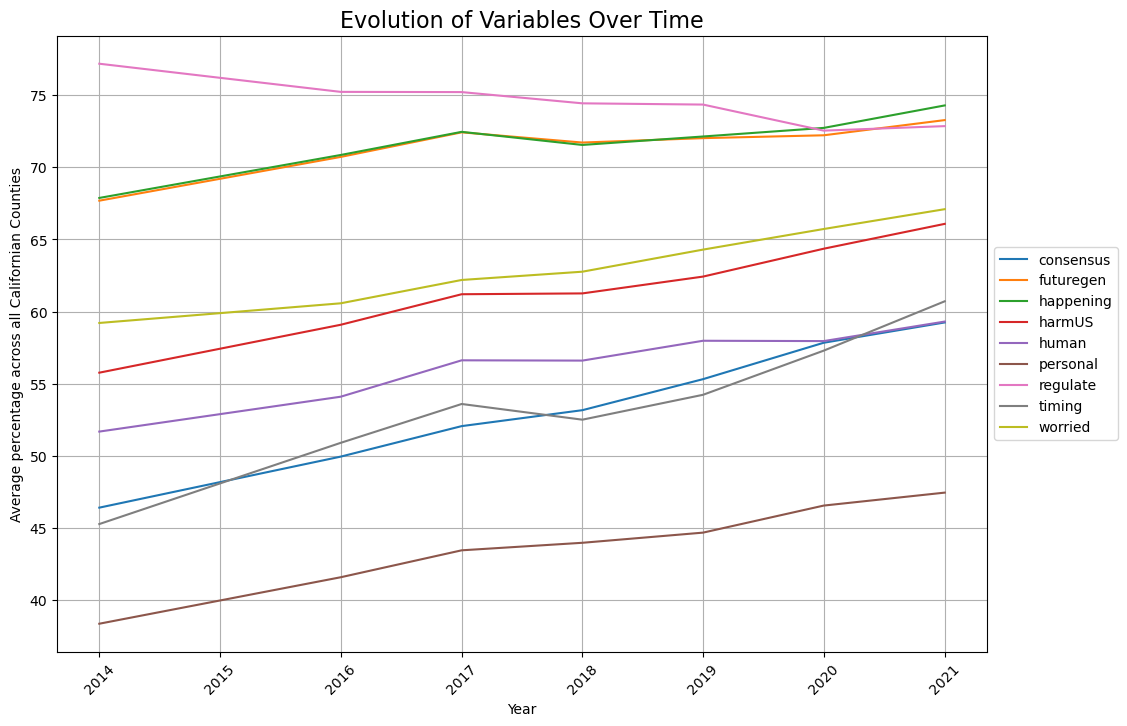

In [73]:
# Convert the "Year" column to datetime
df_opinions['Year'] = pd.to_datetime(df_opinions['Year'], format='%Y')

# Group by "Year" and calculate the average for each variable
grouped_df = df_opinions.groupby('Year').mean()

# Plot the evolution of each variable over time (each belief has two variabnles, for and oppose - we are only plotting the ones for said belief)
plt.figure(figsize=(12, 8))
for col in grouped_df.columns:
    if 'Oppose' not in col:
        plt.plot(grouped_df.index, grouped_df[col], label=col)

plt.title('Evolution of Variables Over Time', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Average percentage across all Californian Counties')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45)
plt.grid(True)
plt.show();

## Climate change data <a class="anchor" id="climate"></a>

In [74]:
df_climate = pd.read_csv('/project/climate_change.csv')

In [75]:
df_climate

,Date,Palmer Drought Severity Index (PDSI),State,Precipitation,Average Temperature
0,1993-02,3.44,California,5.98,44.0
1,1993-03,2.90,California,3.05,52.9
2,1993-04,2.46,California,1.45,55.2
3,1993-05,2.68,California,1.44,62.3
4,1993-06,3.06,California,0.87,68.0
...,...,...,...,...,...
357,2022-11,-4.30,California,2.00,46.6
358,2022-12,-2.97,California,6.41,43.1
359,2023-01,-0.86,California,8.24,42.7
360,2023-02,-0.70,California,3.39,42.8


### Cleaning <a class="anchor" id="climate.1"></a>

In [76]:
# keeping california only
df_climate_ca = df_climate[df_climate['State']=='California']

In [77]:
# Split the 'Date' column into 'Year' and 'Month' columns
df_climate_ca[['Year', 'Month']] = df_climate_ca['Date'].str.split('-', expand=True)

# Convert the 'Year' and 'Month' columns to numeric type
df_climate_ca[['Year', 'Month']] = df_climate_ca[['Year', 'Month']].astype(int)

# Filter the dataframe to keep rows where Year is 2011 or after
df_climate_ca = df_climate_ca[(df_climate_ca['Year'] >= 2011)]

# Print the filtered dataframe
df_climate_ca


,Date,Palmer Drought Severity Index (PDSI),State,Precipitation,Average Temperature,Year,Month
215,2011-01,1.98,California,1.28,45.2,2011,1
216,2011-02,1.82,California,3.34,43.4,2011,2
217,2011-03,3.03,California,6.41,48.7,2011,3
218,2011-04,2.47,California,1.10,53.4,2011,4
219,2011-05,2.82,California,1.44,57.6,2011,5
...,...,...,...,...,...,...,...
357,2022-11,-4.30,California,2.00,46.6,2022,11
358,2022-12,-2.97,California,6.41,43.1,2022,12
359,2023-01,-0.86,California,8.24,42.7,2023,1
360,2023-02,-0.70,California,3.39,42.8,2023,2


In [78]:
df_climate_ca.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147 entries, 215 to 361
Data columns (total 7 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Date                                   147 non-null    object 
 1    Palmer Drought Severity Index (PDSI)  147 non-null    float64
 2   State                                  147 non-null    object 
 3    Precipitation                         147 non-null    float64
 4    Average Temperature                   147 non-null    float64
 5   Year                                   147 non-null    int64  
 6   Month                                  147 non-null    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 9.2+ KB


In [79]:
df_climate_ca.rename(columns={' Palmer Drought Severity Index (PDSI)': 'Palmer Drought Severity Index (PDSI)'}, inplace=True)
df_climate_ca.rename(columns={' Average Temperature': 'Average Temperature'}, inplace=True)
df_climate_ca.rename(columns={' Precipitation': 'Precipitation'}, inplace=True)

In [80]:
df_climate_ca

,Date,Palmer Drought Severity Index (PDSI),State,Precipitation,Average Temperature,Year,Month
215,2011-01,1.98,California,1.28,45.2,2011,1
216,2011-02,1.82,California,3.34,43.4,2011,2
217,2011-03,3.03,California,6.41,48.7,2011,3
218,2011-04,2.47,California,1.10,53.4,2011,4
219,2011-05,2.82,California,1.44,57.6,2011,5
...,...,...,...,...,...,...,...
357,2022-11,-4.30,California,2.00,46.6,2022,11
358,2022-12,-2.97,California,6.41,43.1,2022,12
359,2023-01,-0.86,California,8.24,42.7,2023,1
360,2023-02,-0.70,California,3.39,42.8,2023,2


We are going to calculate the average per year so that it can be merged with the other datasets

In [81]:
df_climate_avg = df_climate_ca.groupby('Year').agg({'Average Temperature': 'mean', 
                                     'Precipitation': 'mean', 
                                     'Palmer Drought Severity Index (PDSI)': 'mean'}).reset_index()


In [82]:
df_climate_avg.columns = ['Year', 'Average_Temperature_per_Year', 'Average_Precipitation_per_Year', 'Average_PDSI_per_Year']


In [83]:
df_climate_avg

,Year,Average_Temperature_per_Year,Average_Precipitation_per_Year,Average_PDSI_per_Year
0,2011,57.433333,1.565833,1.709167
1,2012,59.508333,1.954167,-1.598333
2,2013,59.316667,0.660833,-2.835833
3,2014,61.450000,1.658333,-5.756667
4,2015,60.758333,1.253333,-4.797500
5,2016,60.133333,2.144167,-1.383333
6,2017,60.341667,2.347500,-0.030000
7,2018,60.125000,1.507500,-2.884167
8,2019,58.408333,2.426667,0.704167
9,2020,60.516667,1.005833,-2.325833


### EDA  <a class="anchor" id="climate.2"></a>

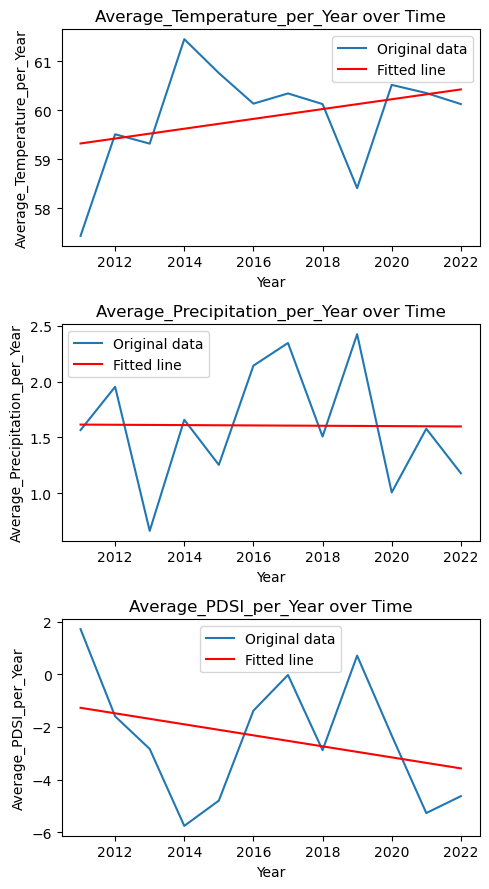

In [84]:
# Select the variables you want to explore
variables_to_explore = ['Average_Temperature_per_Year', 'Average_Precipitation_per_Year', 'Average_PDSI_per_Year']

df_climate_avg_excluded_2023 = df_climate_avg[df_climate_avg['Year'] != 2023] #because the average of 2023 is not realistic since the year is not over

# Set the figure size
plt.figure(figsize=(5, 9))

# Iterate over the selected variables
for i, variable in enumerate(variables_to_explore):
    # Create a subplot for each variable
    plt.subplot(3, 1, i+1)
    
    # Extract the data for the variable
    x = df_climate_avg_excluded_2023['Year']
    y = df_climate_avg_excluded_2023[variable]

    # Fit a linear regression model to the data
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    # Create a range of x values for the predicted line
    x_pred = np.linspace(x.min(), x.max(), 500)
    
    # Calculate the predicted y values
    y_pred = intercept + slope * x_pred
    
    # Plot the data & trendline
    plt.plot(x, y, label='Original data')
    plt.plot(x_pred, y_pred, color='red', label='Fitted line')   

    plt.xlabel('Year')
    plt.ylabel(variable)
    plt.title(f'{variable} over Time')
    plt.legend()

# Adjust the spacing between subplots
plt.tight_layout()

plt.show();

## Washing machines market size <a class="anchor" id="market"></a>

In [85]:
df_market_size = pd.read_csv("/project/cmi_household-appliances_major_only.csv")
df_market_size.head()

,Region,Market,Year,Name,Price per Unit (thousands USD),Revenue by Segment (Billion USD),Revenue Change by Segment (percent),Volume by Segment (Million Pieces)
0,United States,Major Appliances,2018,Washing Machines,0.455,6.351,NaN,13.97
1,United States,Major Appliances,2019,Washing Machines,0.462,6.460,1.716,13.98
2,United States,Major Appliances,2020,Washing Machines,0.467,6.451,-0.139,13.80
3,United States,Major Appliances,2021,Washing Machines,0.477,6.381,-1.085,13.37
4,United States,Major Appliances,2022,Washing Machines,0.488,6.483,1.598,13.28


## Cleaning <a class="anchor" id="market.1"></a>

In [86]:
df_market_size.columns

Index(['Region', 'Market', 'Year', 'Name ', 'Price per Unit (thousands USD)',
       'Revenue by Segment (Billion USD)',
       'Revenue Change by Segment (percent)',
       'Volume by Segment (Million Pieces)'],
      dtype='object')

In [87]:
df_market_size.drop(columns=['Market','Name '],inplace=True)

Values for revenue found on another document from statista for the years 2014 yo 2018:

In [88]:
market_14_18 = pd.read_excel("/project/statistic_id922797_household-appliances-market-revenue-in-the-us-from-2014-2025-by-product-type.xlsx"
                             , sheet_name="Data")
market_14_18.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Household appliances market revenue in the US ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Household appliances market revenue in the Uni...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,Air conditioner & heater,Washing machine,"Mixer, grinder & food processor",Vacuum cleaner,"Cooktop, cooking range, microwave oven & oven",Refrigerator,Dishwasher,Water heater (boiler/geyser)
4,NaN,2014,7,5.8,0.5,1.9,10.9,7.4,4.9,2.1


In [89]:
# rename the columns and drop the ones that are not needed
market_14_18.columns = ['Drop', 'Year', 'Air conditioner & heater', 'Washing machine', 
               'Mixer, grinder & food processor', 'Vacuum cleaner',
               'Cooktop, cooking range, microwave oven & oven', 'Refrigerator',
               'Dishwasher', 'Water heater (boiler/geyser)']

market_14_18 = market_14_18.drop(columns=['Drop'])  # drop the unneeded 'Drop' column
market_14_18 = market_14_18.iloc[4:]  # drop the first 4 rows, which don't contain any data
market_14_18['Year'] = market_14_18['Year'].astype(int)  # ensure that 'Year' is int type
market_14_18.set_index('Year', inplace=True)  # set 'Year' as index
market_14_18

,Air conditioner & heater,Washing machine,"Mixer, grinder & food processor",Vacuum cleaner,"Cooktop, cooking range, microwave oven & oven",Refrigerator,Dishwasher,Water heater (boiler/geyser)
Year,,,,,,,,
2014,7,5.8,0.5,1.9,10.9,7.4,4.9,2.1
2015,7.4,5.8,0.5,1.9,11.2,8.1,4.7,2.3
2016,7.7,6.7,0.5,1.8,12.1,8.1,4.9,2.5
2017,8.1,6.1,0.7,1.8,12.1,8.6,5.1,2.5
2018,8.1,6.3,0.5,2.3,12.4,8.8,5.3,2.5
2019,8.9,6.3,0.7,2.3,13,9.3,5.6,2.5
2020,8.9,7,0.9,2.1,13.7,9.5,5.8,2.6
2021,9.3,7.2,0.7,2.3,13.8,10,5.8,3
2022,9.8,7.2,0.7,2.3,14.4,10.5,5.8,3


The washing machine column refers to the washing machine revenue in billion USD. This will be made clearer when cleaning the dataset.

In [90]:
market_14_18_sub = market_14_18.loc[2014:2017, 'Washing machine'].reset_index()
market_14_18_sub.columns = ['Year', 'Revenue by Segment (Billion USD)']
market_14_18_sub['Year'] = market_14_18_sub['Year'].astype(str)

In [91]:
market_14_18_sub

,Year,Revenue by Segment (Billion USD)
0,2014,5.8
1,2015,5.8
2,2016,6.7
3,2017,6.1


In [92]:
# fill in some columns to then be able to merge this dataset with df_market_size
market_14_18_sub['Region'] = 'United States'
market_14_18_sub['Price per Unit (thousands USD)'] = np.nan
market_14_18_sub['Revenue Change by Segment (percent)'] = np.nan
market_14_18_sub['Volume by Segment (Million Pieces)'] = np.nan

In [93]:
df_washing = pd.concat([df_market_size, market_14_18_sub], ignore_index=True) # merge
df_washing

,Region,Year,Price per Unit (thousands USD),Revenue by Segment (Billion USD),Revenue Change by Segment (percent),Volume by Segment (Million Pieces)
0,United States,2018,0.455,6.351,NaN,13.97
1,United States,2019,0.462,6.46,1.716,13.98
2,United States,2020,0.467,6.451,-0.139,13.80
3,United States,2021,0.477,6.381,-1.085,13.37
4,United States,2022,0.488,6.483,1.598,13.28
5,United States,2023,0.500,6.657,2.684,13.32
6,United States,2024,0.511,6.833,2.644,13.36
7,United States,2025,0.523,7.007,2.546,13.40
8,United States,2026,0.534,7.176,2.412,13.44
9,United States,2027,0.545,7.348,2.397,13.48


In [94]:
# Convert the 'Year' column to integer type
df_washing['Year'] = df_washing['Year'].astype(int)

# Sort by 'Year'
df_washing = df_washing.sort_values('Year')

# Reset index
df_washing = df_washing.reset_index(drop=True)

df_washing

,Region,Year,Price per Unit (thousands USD),Revenue by Segment (Billion USD),Revenue Change by Segment (percent),Volume by Segment (Million Pieces)
0,United States,2014,NaN,5.8,NaN,NaN
1,United States,2015,NaN,5.8,NaN,NaN
2,United States,2016,NaN,6.7,NaN,NaN
3,United States,2017,NaN,6.1,NaN,NaN
4,United States,2018,0.455,6.351,NaN,13.97
5,United States,2019,0.462,6.46,1.716,13.98
6,United States,2020,0.467,6.451,-0.139,13.80
7,United States,2021,0.477,6.381,-1.085,13.37
8,United States,2022,0.488,6.483,1.598,13.28
9,United States,2023,0.500,6.657,2.684,13.32


In [95]:
# Calculate revenue change
df_washing['Revenue Change by Segment (percent)'] = df_washing['Revenue by Segment (Billion USD)'].diff()

In [96]:
df_washing.columns

Index(['Region', 'Year', 'Price per Unit (thousands USD)',
       'Revenue by Segment (Billion USD)',
       'Revenue Change by Segment (percent)',
       'Volume by Segment (Million Pieces)'],
      dtype='object')

In [97]:
to_impute = ['Price per Unit (thousands USD)','Volume by Segment (Million Pieces)']

# Create a copy of the DataFrame to store the imputed values
df_reverse = df_washing.copy()

# To perform backward imputation
df_reverse = df_reverse.iloc[::-1]

for column in to_impute:
    for i in range(4, -1, -1): # Start from index 4 (year 2018) and move to index 0 (year 2014)
        df_reverse.at[i, column] = df_reverse[column].iloc[i+1:i+5].mean()

df_washing = df_reverse.iloc[::-1]

In [98]:
df_washing

,Region,Year,Price per Unit (thousands USD),Revenue by Segment (Billion USD),Revenue Change by Segment (percent),Volume by Segment (Million Pieces)
0,United States,2014,0.52825,5.8,NaN,13.4200
1,United States,2015,0.51700,5.8,0.0,13.3800
2,United States,2016,0.50550,6.7,0.9,13.3400
3,United States,2017,0.49400,6.1,-0.6,13.3325
4,United States,2018,0.48300,6.351,0.251,13.4425
5,United States,2019,0.46200,6.46,0.109,13.9800
6,United States,2020,0.46700,6.451,-0.009,13.8000
7,United States,2021,0.47700,6.381,-0.07,13.3700
8,United States,2022,0.48800,6.483,0.102,13.2800
9,United States,2023,0.50000,6.657,0.174,13.3200


we want to drop the years 2023 and onwards as these are forecasts

In [99]:
# Filter rows where the year is less than or equal to 2022
df_washing = df_washing[df_washing['Year'] < 2022]

In [100]:
df_washing

,Region,Year,Price per Unit (thousands USD),Revenue by Segment (Billion USD),Revenue Change by Segment (percent),Volume by Segment (Million Pieces)
0,United States,2014,0.52825,5.8,NaN,13.4200
1,United States,2015,0.51700,5.8,0.0,13.3800
2,United States,2016,0.50550,6.7,0.9,13.3400
3,United States,2017,0.49400,6.1,-0.6,13.3325
4,United States,2018,0.48300,6.351,0.251,13.4425
5,United States,2019,0.46200,6.46,0.109,13.9800
6,United States,2020,0.46700,6.451,-0.009,13.8000
7,United States,2021,0.47700,6.381,-0.07,13.3700


add a column of the volume and revenue for California based on the overall US, based on population

#### we need df_census for all states to define the total US population per year to calculate the revenue of California only

In [101]:
df_census_us = pd.read_csv('/project/census_df_variables.csv')

In [102]:
us_population = df_census_us.groupby('Year')['Total_population'].sum()
# Filter for California and calculate the population for each year
california_population = df_census.groupby('Year')['Total_population'].sum()

In [103]:
us_population.loc[2020] = 331449281 #because the year 2020 is missing due to Covid-19, however it can instead be found on the US Census Website
us_population = us_population.sort_values(ascending=True)

In [105]:
df_washing_california = df_washing.copy()

df_washing_california['Volume_California_Million_Pieces'] = df_washing_california['Volume by Segment (Million Pieces)'] / df_census['Year'].map(us_population) * df_census['Year'].map(california_population)
df_washing_california['Revenue_California_Billion_USD'] = df_washing_california['Revenue by Segment (Billion USD)'] / df_census['Year'].map(us_population) * df_census['Year'].map(california_population)

In [106]:
df_washing_california

,Region,Year,Price per Unit (thousands USD),Revenue by Segment (Billion USD),Revenue Change by Segment (percent),Volume by Segment (Million Pieces),Volume_California_Million_Pieces,Revenue_California_Billion_USD
0,United States,2014,0.52825,5.8,NaN,13.4200,1.573514,0.680058
1,United States,2015,0.51700,5.8,0.0,13.3800,1.568824,0.680058
2,United States,2016,0.50550,6.7,0.9,13.3400,1.564134,0.785584
3,United States,2017,0.49400,6.1,-0.6,13.3325,1.563254,0.715233
4,United States,2018,0.48300,6.351,0.251,13.4425,1.576152,0.744664
5,United States,2019,0.46200,6.46,0.109,13.9800,1.639174,0.757444
6,United States,2020,0.46700,6.451,-0.009,13.8000,1.618069,0.756389
7,United States,2021,0.47700,6.381,-0.07,13.3700,1.567651,0.748181


In [107]:
df_washing_california.rename(columns={'Price per Unit (thousands USD)':'Price_per_unit_thousands_USD'}, inplace=True)

In [108]:
df_washing_california.drop(columns=['Revenue Change by Segment (percent)','Revenue by Segment (Billion USD)','Volume by Segment (Million Pieces)'],inplace=True)

In [109]:
# Change 'Region' to 'California' 
df_washing_california['Region'] = 'California'

# Create 'Change_revenue' column
df_washing_california['Change_revenue'] = df_washing_california['Revenue_California_Billion_USD'].pct_change()

# Multiply by 100 to get percentage change
df_washing_california['Change_revenue'] *= 100

In [110]:
df_washing_california

,Region,Year,Price_per_unit_thousands_USD,Volume_California_Million_Pieces,Revenue_California_Billion_USD,Change_revenue
0,California,2014,0.52825,1.573514,0.680058,NaN
1,California,2015,0.51700,1.568824,0.680058,0.000000
2,California,2016,0.50550,1.564134,0.785584,15.517241
3,California,2017,0.49400,1.563254,0.715233,-8.955224
4,California,2018,0.48300,1.576152,0.744664,4.114754
5,California,2019,0.46200,1.639174,0.757444,1.716265
6,California,2020,0.46700,1.618069,0.756389,-0.139319
7,California,2021,0.47700,1.567651,0.748181,-1.085103


### EDA <a class="anchor" id="market.2"></a>

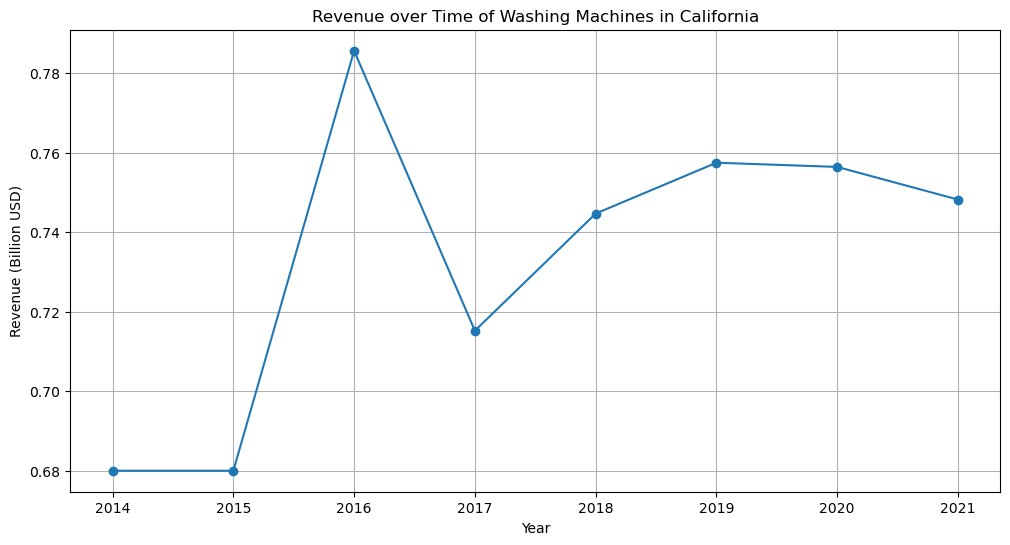

In [111]:
# Plotting Revenue_Billion_USD over time
plt.figure(figsize=(12, 6))
plt.plot(df_washing_california['Year'], df_washing_california['Revenue_California_Billion_USD'], marker='o')
plt.title('Revenue over Time of Washing Machines in California')
plt.xlabel('Year')
plt.ylabel('Revenue (Billion USD)')
plt.grid(True)
plt.show();

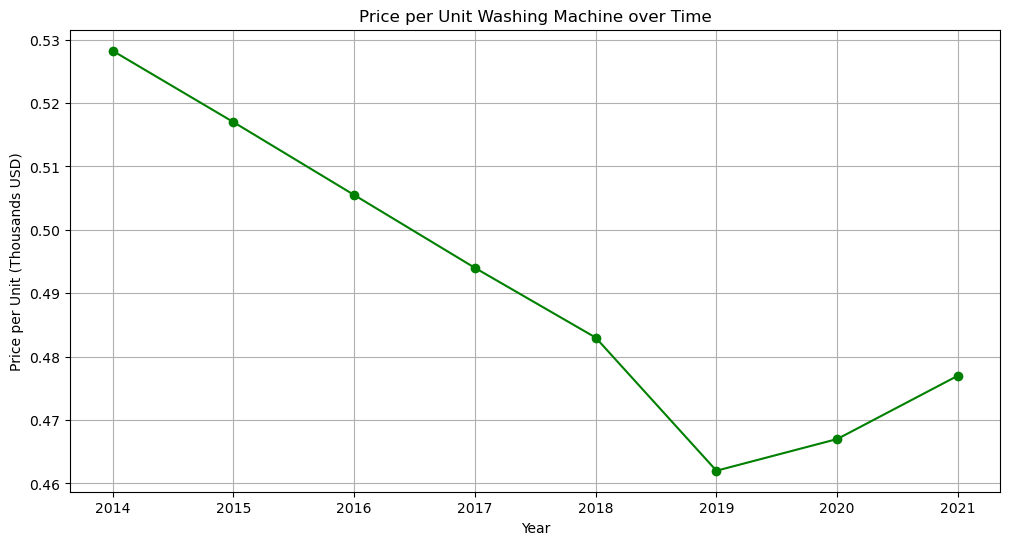

In [112]:
# Plotting Price_per_unit_thousands_USD over time
plt.figure(figsize=(12, 6))
plt.plot(df_washing_california['Year'], df_washing_california['Price_per_unit_thousands_USD'], marker='o', color='green')
plt.title('Price per Unit Washing Machine over Time')
plt.xlabel('Year')
plt.ylabel('Price per Unit (Thousands USD)')
plt.grid(True)
plt.show();


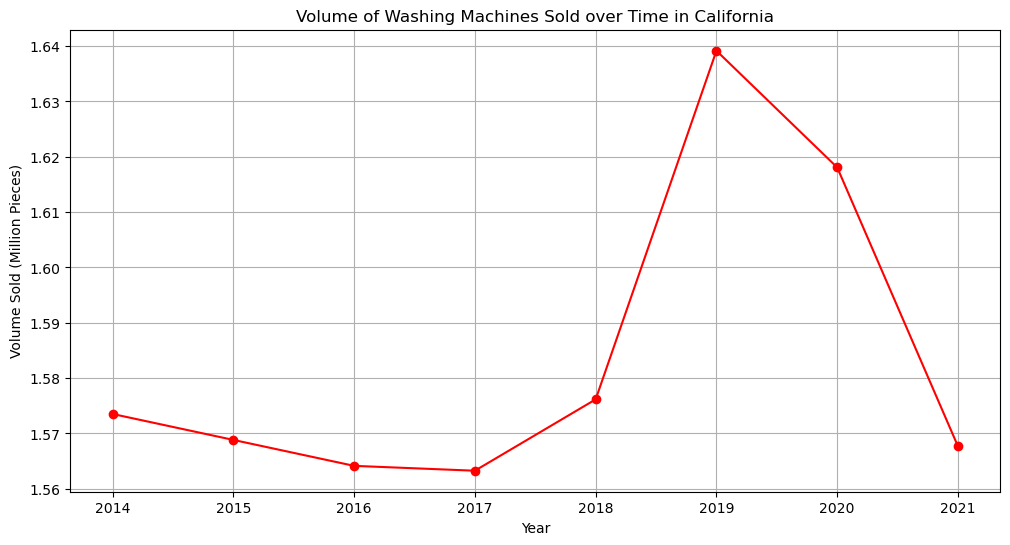

In [113]:
# Plotting Volume_Million_Pieces over time
plt.figure(figsize=(12, 6))
plt.plot(df_washing_california['Year'], df_washing_california['Volume_California_Million_Pieces'], marker='o', color='red')
plt.title('Volume of Washing Machines Sold over Time in California')
plt.xlabel('Year')
plt.ylabel('Volume Sold (Million Pieces)')
plt.grid(True)
plt.show();

# Merging dataset <a class="anchor" id="merging"></a>

In [114]:
df_census

,County_name,State_name,County_code,Year,Total_population,Total_households,Female_population,Male_population,Median_age,Median_household_income_past_12m,Bachelor_degree,Master_degree,Professional_degree,Doctorate_degree,Num_employed,Num_unemployed,Labor_force,Avg_household_size,Median_value_owner_occupied_housing,Households_solar_energy_fuel,Num_under_18,Num_18_to_34,Num_35_to_64,Num_65_more,Num_industry_agriculture_fishing_hunting
0,"Merced County, California",6,47,2011,253606,74079,125935,127671,29.5,43945,NaN,NaN,NaN,NaN,94066,16875,110941,3.37,197700,42,80678,64432,85077,23419,10964
1,"Mariposa County, California",6,43,2011,18290,7607,9031,9259,48.4,49174,NaN,NaN,NaN,NaN,7602,1152,8754,2.28,248900,28,3382,2850,8311,3747,243
2,"Yuba County, California",6,115,2011,71817,23885,35565,36252,31.7,46617,NaN,NaN,NaN,NaN,25417,5218,30635,2.95,194200,10,20968,18084,25691,7074,1077
3,"Contra Costa County, California",6,13,2011,1037817,370925,531217,506600,38.3,79135,NaN,NaN,NaN,NaN,483584,50498,534082,2.77,490200,203,259160,213627,437493,127537,2076
4,"Lassen County, California",6,35,2011,35001,10097,12016,22985,37.0,52484,NaN,NaN,NaN,NaN,10453,1157,11610,2.43,199200,13,6093,10438,15111,3359,490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,"Tulare County, California",6,107,2021,470999,139631,234574,236425,31.3,57394,28347.0,10735.0,2472.0,778.0,187269,21293,208562,3.33,240600,1018,145107,113606,159156,53130,28450
634,"Tuolumne County, California",6,109,2021,55243,23103,26488,28755,48.6,66846,6817.0,2441.0,768.0,370.0,21541,1896,23437,2.24,333500,303,9388,10300,21107,14448,457
635,"Ventura County, California",6,111,2021,845255,274471,424655,420600,38.7,94150,124047.0,48602.0,13872.0,9090.0,410141,24236,434377,3.03,633900,1499,193250,189641,329877,132487,19406
636,"Yolo County, California",6,113,2021,216703,75471,111335,105368,31.5,78386,28159.0,14518.0,5726.0,6596.0,101603,6017,107620,2.77,476000,1865,45449,72655,71440,27159,3681


In [115]:
df_opinions

varname,GeoName,Year,consensus,consensusOppose,futuregen,futuregenOppose,happening,happeningOppose,harmUS,harmUSOppose,human,humanOppose,personal,personalOppose,regulate,regulateOppose,timing,timingOppose,worried,worriedOppose
0,"Alameda County, California",2014-01-01,60.00,23.00,76.00,14.00,80.00,8.00,64.00,26.00,64.00,23.00,46.00,44.00,82.00,16.00,55.00,45.00,71.00,29.00
1,"Alameda County, California",2015-01-01,62.72,21.69,77.94,12.96,81.34,7.30,66.69,24.68,65.46,22.30,48.05,42.91,81.66,16.53,57.76,42.20,71.94,28.00
2,"Alameda County, California",2016-01-01,65.45,20.38,79.89,11.93,82.69,6.59,69.38,23.36,66.91,21.60,50.10,41.83,81.32,17.06,60.52,39.40,72.89,26.99
3,"Alameda County, California",2017-01-01,69.11,18.50,81.89,10.57,84.09,6.02,71.89,21.23,69.60,20.70,52.92,39.60,81.74,16.38,63.54,36.38,74.66,25.18
4,"Alameda County, California",2018-01-01,71.09,17.18,81.44,10.99,83.73,6.42,71.98,20.67,69.97,20.51,53.89,38.93,81.09,17.03,63.16,36.80,75.50,24.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,"Yuba County, California",2017-01-01,48.65,28.84,69.95,19.72,68.74,13.86,57.99,32.41,52.14,32.51,40.75,48.28,73.68,24.46,50.07,49.69,57.55,42.12
460,"Yuba County, California",2018-01-01,49.93,27.73,69.05,21.00,67.41,15.27,57.75,32.66,51.62,32.48,41.03,48.31,72.45,25.80,48.58,51.29,57.89,41.81
461,"Yuba County, California",2019-01-01,51.76,26.67,69.05,20.93,67.59,15.22,58.61,31.55,52.29,32.60,41.42,47.85,71.74,26.60,49.98,50.02,59.15,40.62
462,"Yuba County, California",2020-01-01,53.64,25.80,68.97,21.63,67.91,16.13,60.55,30.49,51.62,32.60,43.05,47.20,69.30,29.34,52.77,47.23,60.30,39.52


In [116]:
df_climate_avg

,Year,Average_Temperature_per_Year,Average_Precipitation_per_Year,Average_PDSI_per_Year
0,2011,57.433333,1.565833,1.709167
1,2012,59.508333,1.954167,-1.598333
2,2013,59.316667,0.660833,-2.835833
3,2014,61.450000,1.658333,-5.756667
4,2015,60.758333,1.253333,-4.797500
5,2016,60.133333,2.144167,-1.383333
6,2017,60.341667,2.347500,-0.030000
7,2018,60.125000,1.507500,-2.884167
8,2019,58.408333,2.426667,0.704167
9,2020,60.516667,1.005833,-2.325833


In [117]:
df_washing_california

,Region,Year,Price_per_unit_thousands_USD,Volume_California_Million_Pieces,Revenue_California_Billion_USD,Change_revenue
0,California,2014,0.52825,1.573514,0.680058,NaN
1,California,2015,0.51700,1.568824,0.680058,0.000000
2,California,2016,0.50550,1.564134,0.785584,15.517241
3,California,2017,0.49400,1.563254,0.715233,-8.955224
4,California,2018,0.48300,1.576152,0.744664,4.114754
5,California,2019,0.46200,1.639174,0.757444,1.716265
6,California,2020,0.46700,1.618069,0.756389,-0.139319
7,California,2021,0.47700,1.567651,0.748181,-1.085103


In [118]:
# Because this must be the same datatype to be able to merge the dataframes
df_opinions['Year'] = df_opinions['Year'].dt.year 

In [119]:
# Rename 'county_name' to 'GeoName' in df_census for consistency
df_census = df_census.rename(columns={'County_name': 'GeoName'})

# Merge df_census and df_opinions, which are both at the county level:
df_county = pd.merge(df_census, df_opinions, on=['Year', 'GeoName'])

# Merge df_climate and df_washing_california, which are both year-level:
df_year = pd.merge(df_climate_avg, df_washing_california, on='Year')

# Merge df_county with df_year on the 'Year' column
df_merged = pd.merge(df_county, df_year, on='Year')

# Filter the merged data for years from 2014 to 2021:
df_final = df_merged[(df_merged['Year'] >= 2014) & (df_merged['Year'] <= 2021)]

In [120]:
df_final

,GeoName,State_name,County_code,Year,Total_population,Total_households,Female_population,Male_population,Median_age,Median_household_income_past_12m,Bachelor_degree,Master_degree,Professional_degree,Doctorate_degree,Num_employed,Num_unemployed,Labor_force,Avg_household_size,Median_value_owner_occupied_housing,Households_solar_energy_fuel,Num_under_18,Num_18_to_34,Num_35_to_64,Num_65_more,Num_industry_agriculture_fishing_hunting,consensus,consensusOppose,futuregen,futuregenOppose,happening,happeningOppose,harmUS,harmUSOppose,human,humanOppose,personal,personalOppose,regulate,regulateOppose,timing,timingOppose,worried,worriedOppose,Average_Temperature_per_Year,Average_Precipitation_per_Year,Average_PDSI_per_Year,Region,Price_per_unit_thousands_USD,Volume_California_Million_Pieces,Revenue_California_Billion_USD,Change_revenue
0,"Lake County, California",6,33,2014,64209,26771,31910,32299,45.2,35997,4935.0,1745.0,420.0,344.0,22288,4452,26740,2.36,167900,24,13209,11750,27089,12161,1238,44.00,32.00,67.00,22.00,66.00,15.00,53.00,37.00,51.00,33.00,35.00,53.00,78.00,21.00,43.00,56.00,57.00,43.00,61.45,1.658333,-5.756667,California,0.52825,1.573514,0.680058,NaN
1,"Modoc County, California",6,49,2014,9335,3893,4608,4727,47.1,38560,955.0,144.0,95.0,59.0,3517,495,4012,2.25,157300,0,1981,1491,3886,1977,544,45.00,31.00,65.00,24.00,66.00,15.00,51.00,39.00,47.00,35.00,34.00,54.00,74.00,26.00,42.00,56.00,55.00,44.00,61.45,1.658333,-5.756667,California,0.52825,1.573514,0.680058,NaN
2,"Inyo County, California",6,27,2014,18439,7891,9171,9268,45.3,45625,1800.0,730.0,190.0,115.0,8336,713,9049,2.27,235200,0,3879,3318,7583,3659,223,45.00,31.00,66.00,23.00,67.00,15.00,54.00,37.00,49.00,34.00,36.00,53.00,77.00,23.00,43.00,56.00,57.00,42.00,61.45,1.658333,-5.756667,California,0.52825,1.573514,0.680058,NaN
3,"Santa Barbara County, California",6,83,2014,431555,142028,215185,216370,33.6,63409,49596.0,21078.0,6943.0,5951.0,198675,19444,218119,2.91,446500,263,98110,124841,150825,57779,16458,50.00,27.00,68.00,21.00,70.00,11.00,59.00,32.00,54.00,28.00,42.00,48.00,77.00,21.00,48.00,50.00,62.00,37.00,61.45,1.658333,-5.756667,California,0.52825,1.573514,0.680058,NaN
4,"Imperial County, California",6,25,2014,177026,46952,86290,90736,31.9,41772,9993.0,3361.0,718.0,132.0,57838,12765,70603,3.55,145200,12,50993,44506,61706,19821,5450,43.00,27.00,67.00,18.00,67.00,12.00,59.00,27.00,54.00,29.00,44.00,40.00,76.00,22.00,46.00,53.00,62.00,38.00,61.45,1.658333,-5.756667,California,0.52825,1.573514,0.680058,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,"Tulare County, California",6,107,2021,470999,139631,234574,236425,31.3,57394,28347.0,10735.0,2472.0,778.0,187269,21293,208562,3.33,240600,1018,145107,113606,159156,53130,28450,54.31,22.13,71.13,18.00,71.72,12.95,66.24,23.77,58.99,28.95,49.73,38.96,69.05,28.61,59.14,40.86,67.42,32.44,60.35,1.577500,-5.269167,California,0.47700,1.567651,0.748181,-1.085103
460,"Tuolumne County, California",6,109,2021,55243,23103,26488,28755,48.6,66846,6817.0,2441.0,768.0,370.0,21541,1896,23437,2.24,333500,303,9388,10300,21107,14448,457,49.70,29.57,66.97,24.04,66.28,18.34,57.65,34.27,49.40,37.36,39.40,51.00,68.34,30.35,52.33,47.67,56.83,43.12,60.35,1.577500,-5.269167,California,0.47700,1.567651,0.748181,-1.085103
461,"Ventura County, California",6,111,2021,845255,274471,424655,420600,38.7,94150,124047.0,48602.0,13872.0,9090.0,410141,24236,434377,3.03,633900,1499,193250,189641,329877,132487,19406,59.94,23.47,72.73,18.30,75.06,12.08,65.69,26.61,59.21,29.69,47.60,43.52,73.48,25.07,60.09,39.91,68.20,31.81,60.35,1.577500,-5.269167,California,0.47700,1.567651,0.748181,-1.085103
462,"Yolo County, California",6,113,2021,216703,75471,111335,105368,31.5,78386,28159.0,14518.0,5726.0,6596.0,101603,6017,107620,2.77,476000,1865,45449,72655,71440,27159,3681,65.52,20.02,77.89,14.95,80.00,8.49,71.5

In [121]:
df_final.columns

Index(['GeoName', 'State_name', 'County_code', 'Year', 'Total_population',
       'Total_households', 'Female_population', 'Male_population',
       'Median_age', 'Median_household_income_past_12m', 'Bachelor_degree',
       'Master_degree', 'Professional_degree', 'Doctorate_degree',
       'Num_employed', 'Num_unemployed', 'Labor_force', 'Avg_household_size',
       'Median_value_owner_occupied_housing', 'Households_solar_energy_fuel',
       'Num_under_18', 'Num_18_to_34', 'Num_35_to_64', 'Num_65_more',
       'Num_industry_agriculture_fishing_hunting', 'consensus',
       'consensusOppose', 'futuregen', 'futuregenOppose', 'happening',
       'happeningOppose', 'harmUS', 'harmUSOppose', 'human', 'humanOppose',
       'personal', 'personalOppose', 'regulate', 'regulateOppose', 'timing',
       'timingOppose', 'worried', 'worriedOppose',
       'Average_Temperature_per_Year', 'Average_Precipitation_per_Year',
       'Average_PDSI_per_Year', 'Region', 'Price_per_unit_thousands_USD',
   

In [122]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 464 entries, 0 to 463
Data columns (total 51 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   GeoName                                   464 non-null    object 
 1   State_name                                464 non-null    int64  
 2   County_code                               464 non-null    int64  
 3   Year                                      464 non-null    int64  
 4   Total_population                          464 non-null    int64  
 5   Total_households                          464 non-null    int64  
 6   Female_population                         464 non-null    int64  
 7   Male_population                           464 non-null    int64  
 8   Median_age                                464 non-null    float64
 9   Median_household_income_past_12m          464 non-null    int64  
 10  Bachelor_degree                       

In [123]:
df_final.drop(columns = ['Change_revenue', 'State_name','County_code'],inplace=True)

In [124]:
df_final

,GeoName,Year,Total_population,Total_households,Female_population,Male_population,Median_age,Median_household_income_past_12m,Bachelor_degree,Master_degree,Professional_degree,Doctorate_degree,Num_employed,Num_unemployed,Labor_force,Avg_household_size,Median_value_owner_occupied_housing,Households_solar_energy_fuel,Num_under_18,Num_18_to_34,Num_35_to_64,Num_65_more,Num_industry_agriculture_fishing_hunting,consensus,consensusOppose,futuregen,futuregenOppose,happening,happeningOppose,harmUS,harmUSOppose,human,humanOppose,personal,personalOppose,regulate,regulateOppose,timing,timingOppose,worried,worriedOppose,Average_Temperature_per_Year,Average_Precipitation_per_Year,Average_PDSI_per_Year,Region,Price_per_unit_thousands_USD,Volume_California_Million_Pieces,Revenue_California_Billion_USD
0,"Lake County, California",2014,64209,26771,31910,32299,45.2,35997,4935.0,1745.0,420.0,344.0,22288,4452,26740,2.36,167900,24,13209,11750,27089,12161,1238,44.00,32.00,67.00,22.00,66.00,15.00,53.00,37.00,51.00,33.00,35.00,53.00,78.00,21.00,43.00,56.00,57.00,43.00,61.45,1.658333,-5.756667,California,0.52825,1.573514,0.680058
1,"Modoc County, California",2014,9335,3893,4608,4727,47.1,38560,955.0,144.0,95.0,59.0,3517,495,4012,2.25,157300,0,1981,1491,3886,1977,544,45.00,31.00,65.00,24.00,66.00,15.00,51.00,39.00,47.00,35.00,34.00,54.00,74.00,26.00,42.00,56.00,55.00,44.00,61.45,1.658333,-5.756667,California,0.52825,1.573514,0.680058
2,"Inyo County, California",2014,18439,7891,9171,9268,45.3,45625,1800.0,730.0,190.0,115.0,8336,713,9049,2.27,235200,0,3879,3318,7583,3659,223,45.00,31.00,66.00,23.00,67.00,15.00,54.00,37.00,49.00,34.00,36.00,53.00,77.00,23.00,43.00,56.00,57.00,42.00,61.45,1.658333,-5.756667,California,0.52825,1.573514,0.680058
3,"Santa Barbara County, California",2014,431555,142028,215185,216370,33.6,63409,49596.0,21078.0,6943.0,5951.0,198675,19444,218119,2.91,446500,263,98110,124841,150825,57779,16458,50.00,27.00,68.00,21.00,70.00,11.00,59.00,32.00,54.00,28.00,42.00,48.00,77.00,21.00,48.00,50.00,62.00,37.00,61.45,1.658333,-5.756667,California,0.52825,1.573514,0.680058
4,"Imperial County, California",2014,177026,46952,86290,90736,31.9,41772,9993.0,3361.0,718.0,132.0,57838,12765,70603,3.55,145200,12,50993,44506,61706,19821,5450,43.00,27.00,67.00,18.00,67.00,12.00,59.00,27.00,54.00,29.00,44.00,40.00,76.00,22.00,46.00,53.00,62.00,38.00,61.45,1.658333,-5.756667,California,0.52825,1.573514,0.680058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,"Tulare County, California",2021,470999,139631,234574,236425,31.3,57394,28347.0,10735.0,2472.0,778.0,187269,21293,208562,3.33,240600,1018,145107,113606,159156,53130,28450,54.31,22.13,71.13,18.00,71.72,12.95,66.24,23.77,58.99,28.95,49.73,38.96,69.05,28.61,59.14,40.86,67.42,32.44,60.35,1.577500,-5.269167,California,0.47700,1.567651,0.748181
460,"Tuolumne County, California",2021,55243,23103,26488,28755,48.6,66846,6817.0,2441.0,768.0,370.0,21541,1896,23437,2.24,333500,303,9388,10300,21107,14448,457,49.70,29.57,66.97,24.04,66.28,18.34,57.65,34.27,49.40,37.36,39.40,51.00,68.34,30.35,52.33,47.67,56.83,43.12,60.35,1.577500,-5.269167,California,0.47700,1.567651,0.748181
461,"Ventura County, California",2021,845255,274471,424655,420600,38.7,94150,124047.0,48602.0,13872.0,9090.0,410141,24236,434377,3.03,633900,1499,193250,189641,329877,132487,19406,59.94,23.47,72.73,18.30,75.06,12.08,65.69,26.61,59.21,29.69,47.60,43.52,73.48,25.07,60.09,39.91,68.20,31.81,60.35,1.577500,-5.269167,California,0.47700,1.567651,0.748181
462,"Yolo County, California",2021,216703,75471,111335,105368,31.5,78386,28159.0,14518.0,5726.0,6596.0,101603,6017,107620,2.77,476000,1865,45449,72655,71440,27159,3681,65.52,20.02,77.89,14.95,80.00,8.49,71.52,22.32,65.93,23.54,52.53,41.05,77.24,21.19,65.54,34.46,73.61,26.31,60.35,1.577500,-5.269167,California,0.47700,1.567651,0.748181


In [126]:
df_final.to_csv('df_final.csv', index=False)